### Inclinación (40 clústers)

In [1]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
from ipywidgets import interact, widgets
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import seaborn as sns
import os
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
import datetime
from sklearn.cluster import KMeans
from geopy.distance import geodesic 
import warnings
from collections import defaultdict
import requests
import uuid
import random

In [51]:
df = pd.read_csv("cluster_metrics.csv")
# Redondear las coordenadas a 3 decimales
df['Lat_Rounded'] = df['Centroide_Lat'].round(3)
df['Lon_Rounded'] = df['Centroide_Lon'].round(3)

# Eliminar filas duplicadas basadas en las coordenadas redondeadas
unique_coords = df[['Lat_Rounded', 'Lon_Rounded']].drop_duplicates()

# Crear un diccionario para almacenar las altitudes
altitudes = {}

# Iterar sobre las coordenadas únicas y hacer solicitudes a la API
for _, row in unique_coords.iterrows():
    lat = row['Lat_Rounded']
    lon = row['Lon_Rounded']
    url = f'https://api.open-meteo.com/v1/elevation?latitude={lat}&longitude={lon}'
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        elevation = data.get('elevation', None)
        if elevation is not None:
            # Convertir la altitud a cadena y eliminar corchetes si existen
            elevation_str = str(elevation).replace('[', '').replace(']', '')
            altitudes[(lat, lon)] = elevation_str
        else:
            altitudes[(lat, lon)] = None
    else:
        altitudes[(lat, lon)] = None

# Crear una nueva columna en el DataFrame original para las altitudes
df['Altitud'] = df.apply(lambda x: altitudes.get((x['Lat_Rounded'], x['Lon_Rounded'])), axis=1)

# Eliminar las columnas temporales
df.drop(columns=['Lat_Rounded', 'Lon_Rounded'], inplace=True)
df

Cluster_ID  Centroide_Lat  Centroide_Lon  Distancia_Media_km  Num_Puntos  \
0            0      41.879856      12.510375            0.447526        3037   
1            1      41.909890      12.472796            0.415460        1764   
2            2      41.855957      12.479274            0.393418        1123   
3            3      41.914119      12.521666            0.438023         894   
4            4      41.904979      12.511413            0.483289         432   
5            5      41.888195      12.471115            0.349055        1869   
6            6      41.892500      12.492634            0.384945        2040   
7            7      41.881260      12.459078            0.344616        2040   
8            8      41.885580      12.520644            0.377824        1593   
9            9      41.918420      12.459865            0.386741         973   
10          10      41.925987      12.466829            0.447158         591   
11          11      41.833298      12.464004            0.346920         907   
12          12      41.830730      12.472889            0.402806         280   
13          13      41.822503      12.478084            0.451850         314   
14          14      41.819878      12.463371            0.588829         128   
15          15      41.931340      12.519139            0.437415         580   
16          16      41.923752      12.513250            0.349374         888   
17          17      41.865139      12.467326            0.376820         670   
18          18      41.876301      12.469078            0.397437        1664   
19          19      41.924553      12.482086            0.457805         508   
20          20      41.921644      12.494997            0.449361         542   
21          21      41.908886      12.458043            0.360889        1219   
22          22      41.936051      12.467410            0.312457         593   
23          23      41.945863      12.467241            0.492668         429   
24          24      41.874964      12.523325            0.444569        3600   
25          25      41.915668      12.505329            0.403357         999   
26          26      41.908470      12.496686            0.383530         854   
27          27      41.899060      12.469156            0.388222        1429   
28          28      41.904373      12.482278            0.385952        2188   
29          29      41.889445      12.508382            0.441695        2020   
30          30      41.875608      12.480139            0.411807        1480   
31          31      41.882514      12.486746            0.362637         797   
32          32      41.899340      12.500051            0.351519        1662   
33          33      41.874211      12.452789            0.433657        1518   
34          34      41.866547      12.488816            0.403574         925   
35          35      41.859118      12.498262            0.551572         497   
36          36      41.894851      12.479053            0.361347        1953   
37          37      41.846041      12.485965            0.338903        1669   
38          38      41.908197      12.446296            0.388874         828   
39          39      41.897202      12.450496            0.471640         471   

    Pct_Origen  Pct_Destino Altitud  
0    50.444518    49.555482    44.0  
1    50.850340    49.149660    10.0  
2    50.578807    49.421193    14.0  
3    49.776286    50.223714    45.0  
4    47.916667    52.083333    62.0  
5    49.491707    50.508293    30.0  
6    50.833333    49.166667    50.0  
7    49.558824    50.441176    72.0  
8    47.080979    52.919021    54.0  
9    52.312436    47.687564    19.0  
10   52.453469    47.546531    19.0  
11   53.472988    46.527012    34.0  
12   49.642857    50.357143    31.0  
13   47.133758    52.866242    34.0  
14   37.500000    62.500000    26.0  
15   47.931034    52.068966    42.0  
16   51.801802    48.198198    43.0  
17   49.104478    50.895522    20.0  
1

### Consumo de Energía (40 clústers)


In [5]:
import pandas as pd

# Verificar los tipos de datos
print(df.dtypes)

# Parámetros del patinete
consumo_base = 13.5  # Consumo base en Wh/km
k_inclinacion = 0.1  # Factor de ajuste por inclinación (aumenta el consumo por cada 1% de inclinación)

# Convertir a numérico
df['Altitud'] = pd.to_numeric(df['Altitud'], errors='coerce')
df['Distancia_Media_km'] = pd.to_numeric(df['Distancia_Media_km'], errors='coerce')

# Manejar valores nulos
df = df.dropna(subset=['Altitud', 'Distancia_Media_km'])

# Función para calcular el consumo energético de cada viaje
def calcular_consumo(row):
    distancia_km = row['Distancia_Media_km'] / 1000  # Convertimos de metros a kilómetros
    consumo_ajustado = consumo_base * (1 + k_inclinacion * row['Altitud'] / 100)
    consumo_energia = consumo_ajustado * distancia_km  # en Wh
    return consumo_energia

# Calcular el consumo de energía
df['consumo_energia'] = df.apply(calcular_consumo, axis=1)

# Mostrar resultados
print(df[['Cluster_ID', 'Distancia_Media_km', 'Altitud', 'consumo_energia']].head())


Cluster_ID              int64
Centroide_Lat         float64
Centroide_Lon         float64
Distancia_Media_km    float64
Num_Puntos              int64
Pct_Origen            float64
Pct_Destino           float64
Altitud                object
dtype: object
   Cluster_ID  Distancia_Media_km  Altitud  consumo_energia
0           0            0.447526     44.0         0.006307
1           1            0.415460     10.0         0.005665
2           2            0.393418     14.0         0.005385
3           3            0.438023     45.0         0.006179
4           4            0.483289     62.0         0.006929


### Demanda de energía por estación (40 clústers)


In [7]:
df = pd.read_csv("df_with_clusters.csv")

# Definir la capacidad de la batería y el tiempo de recarga
capacidad_bateria = 576  # en Wh
tiempo_recarga = 7  # en horas

# Calcular la potencia demandada por cada patinete (en W)
potencia_demandada_por_patinete = capacidad_bateria / tiempo_recarga  # en W

# Función para calcular la energía demandada por cada estación en un intervalo de tiempo
def calcular_demanda_energia(df, intervalo='H'):
    # Agrupar los datos por cluster de origen (estaciones) y por hora
    df['tsO'] = pd.to_datetime(df['tsO'])  # Asegurarse de que 'tsO' es tipo datetime
    df['hora'] = df['tsO'].dt.floor(intervalo)  # Redondear la hora a intervalos

    # Contar cuántos patinetes recargan en cada intervalo de tiempo y estación (clúster de origen)
    demanda_por_intervalo = df.groupby(['clusterO', 'hora']).size().reset_index(name='num_patinetes')

    # Calcular la demanda de energía en Wh por cada intervalo de tiempo
    demanda_por_intervalo['energia_demandada'] = demanda_por_intervalo['num_patinetes'] * potencia_demandada_por_patinete

    return demanda_por_intervalo

# Llamar a la función y obtener el resultado
demanda_energia = calcular_demanda_energia(df)
print(demanda_energia)


       clusterO                hora  num_patinetes  energia_demandada
0             0 2021-02-01 08:00:00              4         329.142857
1             0 2021-02-01 09:00:00              1          82.285714
2             0 2021-02-01 10:00:00              2         164.571429
3             0 2021-02-01 11:00:00              1          82.285714
4             0 2021-02-01 12:00:00              3         246.857143
...         ...                 ...            ...                ...
10499        39 2021-02-28 13:00:00              3         246.857143
10500        39 2021-02-28 14:00:00              2         164.571429
10501        39 2021-02-28 15:00:00              1          82.285714
10502        39 2021-02-28 16:00:00              1          82.285714
10503        39 2021-02-28 21:00:00              2         164.571429

[10504 rows x 4 columns]


### Inclinación (79 clústers)

In [9]:
df = pd.read_csv("cluster_metrics2.csv")
# Supongamos que tu DataFrame se llama df y tiene las columnas 'Centroide_Lat' y 'Centroide_Lon'
# Redondear las coordenadas a 3 decimales
df['Lat_Rounded'] = df['Centroide_Lat'].round(3)
df['Lon_Rounded'] = df['Centroide_Lon'].round(3)

# Eliminar filas duplicadas basadas en las coordenadas redondeadas
unique_coords = df[['Lat_Rounded', 'Lon_Rounded']].drop_duplicates()

# Crear un diccionario para almacenar las altitudes
altitudes = {}

# Iterar sobre las coordenadas únicas y hacer solicitudes a la API
for _, row in unique_coords.iterrows():
    lat = row['Lat_Rounded']
    lon = row['Lon_Rounded']
    url = f'https://api.open-meteo.com/v1/elevation?latitude={lat}&longitude={lon}'
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        elevation = data.get('elevation', None)
        if elevation is not None:
            # Convertir la altitud a cadena y eliminar corchetes si existen
            elevation_str = str(elevation).replace('[', '').replace(']', '')
            altitudes[(lat, lon)] = elevation_str
        else:
            altitudes[(lat, lon)] = None
    else:
        altitudes[(lat, lon)] = None

# Crear una nueva columna en el DataFrame original para las altitudes
df['Altitud'] = df.apply(lambda x: altitudes.get((x['Lat_Rounded'], x['Lon_Rounded'])), axis=1)

# Eliminar las columnas temporales
df.drop(columns=['Lat_Rounded', 'Lon_Rounded'], inplace=True)
df

Cluster_ID  Centroide_Lat  Centroide_Lon  Distancia_Media_km  Num_Puntos  \
0            0      41.904979      12.511413            0.483289         432   
1            1      41.925987      12.466829            0.447158         591   
2            2      41.830730      12.472889            0.402806         280   
3            3      41.822503      12.478084            0.451850         314   
4            4      41.931340      12.519139            0.437415         580   
..         ...            ...            ...                 ...         ...   
74          74      41.844364      12.483699            0.234220         822   
75          75      41.848672      12.486664            0.220004         475   
76          76      41.846385      12.490081            0.215952         372   
77          77      41.910376      12.447078            0.347202         503   
78          78      41.904808      12.445079            0.275490         325   

    Pct_Origen  Pct_Destino Altitud  
0    47.916667    52.083333    62.0  
1    52.453469    47.546531    19.0  
2    49.642857    50.357143    31.0  
3    47.133758    52.866242    34.0  
4    47.931034    52.068966    42.0  
..         ...          ...     ...  
74   48.783455    51.216545    39.0  
75   56.210526    43.789474    35.0  
76   47.580645    52.419355    48.0  
77   52.882704    47.117296    41.0  
78   39.692308    60.307692    32.0  

[79 rows x 8 columns]

### Consumo de Energía 79 clústers (descartado)


In [11]:
import pandas as pd

# Verificar los tipos de datos
print(df.dtypes)

# Convertir a numérico
df['Altitud'] = pd.to_numeric(df['Altitud'], errors='coerce')
df['Distancia_Media_km'] = pd.to_numeric(df['Distancia_Media_km'], errors='coerce')

# Manejar valores nulos
df = df.dropna(subset=['Altitud', 'Distancia_Media_km'])

# Función para calcular el consumo energético de cada viaje
def calcular_consumo(row):
    distancia_km = row['Distancia_Media_km'] / 1000  # Convertimos de metros a kilómetros
    consumo_ajustado = consumo_base * (1 + k_inclinacion * row['Altitud'] / 100)
    consumo_energia = consumo_ajustado * distancia_km  # en Wh
    return consumo_energia

# Calcular el consumo de energía
df['consumo_energia'] = df.apply(calcular_consumo, axis=1)

# Mostrar resultados
print(df[['Cluster_ID', 'Distancia_Media_km', 'Altitud', 'consumo_energia']].head())


Cluster_ID              int64
Centroide_Lat         float64
Centroide_Lon         float64
Distancia_Media_km    float64
Num_Puntos              int64
Pct_Origen            float64
Pct_Destino           float64
Altitud                object
dtype: object
   Cluster_ID  Distancia_Media_km  Altitud  consumo_energia
0           0            0.483289     62.0         0.006929
1           1            0.447158     19.0         0.006151
2           2            0.402806     31.0         0.005606
3           3            0.451850     34.0         0.006307
4           4            0.437415     42.0         0.006153


### Demanda de energía por estación 79 clústers (descartado)


In [13]:
df = pd.read_csv("df_with_clusters2.csv")

# Definir la capacidad de la batería y el tiempo de recarga
capacidad_bateria = 576  # en Wh
tiempo_recarga = 7  # en horas

# Calcular la potencia demandada por cada patinete (en W)
potencia_demandada_por_patinete = capacidad_bateria / tiempo_recarga  # en W

# Función para calcular la energía demandada por cada estación en un intervalo de tiempo
def calcular_demanda_energia(df, intervalo='H'):
    # Agrupar los datos por cluster de origen (estaciones) y por hora
    df['tsO'] = pd.to_datetime(df['tsO'])  # Asegurarse de que 'tsO' es tipo datetime
    df['hora'] = df['tsO'].dt.floor(intervalo)  # Redondear la hora a intervalos

    # Contar cuántos patinetes recargan en cada intervalo de tiempo y estación (clúster de origen)
    demanda_por_intervalo = df.groupby(['clusterO', 'hora']).size().reset_index(name='num_patinetes')

    # Calcular la demanda de energía en Wh por cada intervalo de tiempo
    demanda_por_intervalo['energia_demandada'] = demanda_por_intervalo['num_patinetes'] * potencia_demandada_por_patinete

    return demanda_por_intervalo

# Llamar a la función y obtener el resultado
demanda_energia = calcular_demanda_energia(df)
print(demanda_energia)


       clusterO                hora  num_patinetes  energia_demandada
0             0 2021-02-01 09:00:00              1          82.285714
1             0 2021-02-01 16:00:00              1          82.285714
2             0 2021-02-01 17:00:00              1          82.285714
3             0 2021-02-01 18:00:00              1          82.285714
4             0 2021-02-01 19:00:00              1          82.285714
...         ...                 ...            ...                ...
14878        78 2021-02-28 10:00:00              1          82.285714
14879        78 2021-02-28 12:00:00              1          82.285714
14880        78 2021-02-28 14:00:00              1          82.285714
14881        78 2021-02-28 18:00:00              1          82.285714
14882        78 2021-02-28 21:00:00              1          82.285714

[14883 rows x 4 columns]


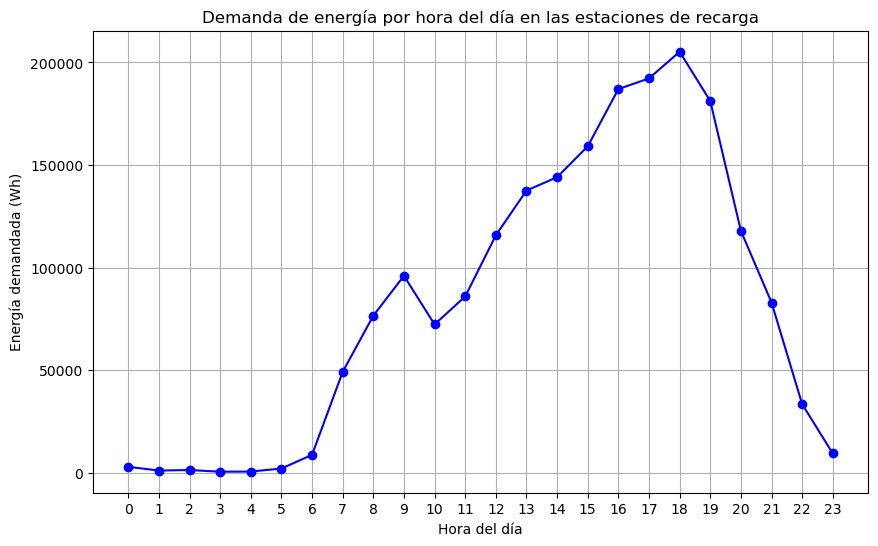

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Definir la capacidad de la batería y el tiempo de recarga
capacidad_bateria = 576  # en Wh
tiempo_recarga = 7  # en horas

# Calcular la potencia demandada por cada patinete (en W)
potencia_demandada_por_patinete = capacidad_bateria / tiempo_recarga  # en W

# Función para calcular la energía demandada por cada estación en cada hora
def calcular_demanda_energia(df, intervalo='H'):
    # Convertir la columna 'tsO' a datetime
    df['tsO'] = pd.to_datetime(df['tsO'])  # Asegurarse de que 'tsO' es tipo datetime
    df['hora'] = df['tsO'].dt.hour  # Extraer solo la hora del día

    # Contar cuántos patinetes recargan en cada hora
    demanda_por_intervalo = df.groupby(['hora']).size().reset_index(name='num_patinetes')

    # Calcular la demanda de energía en Wh por cada intervalo de hora
    demanda_por_intervalo['energia_demandada'] = demanda_por_intervalo['num_patinetes'] * potencia_demandada_por_patinete

    return demanda_por_intervalo



# Calcular la demanda de energía por hora
demanda_energia = calcular_demanda_energia(df)

# Graficar la demanda de energía por hora del día
plt.figure(figsize=(10, 6))
plt.plot(demanda_energia['hora'], demanda_energia['energia_demandada'], marker='o', linestyle='-', color='b')

plt.xlabel('Hora del día')
plt.ylabel('Energía demandada (Wh)')
plt.title('Demanda de energía por hora del día en las estaciones de recarga')
plt.grid(True)
plt.xticks(np.arange(0, 24, 1))  # Marcar cada hora
plt.show()


In [15]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Definir la capacidad de la batería y el tiempo de recarga
capacidad_bateria = 576  # en Wh
tiempo_recarga = 7  # en horas

# Calcular la potencia demandada por cada patinete (en W)
potencia_demandada_por_patinete = capacidad_bateria / tiempo_recarga  # en W

# Función para calcular la demanda de energía por estación y por hora
def calcular_demanda_energia(df, intervalo='H'):
    # Convertir la columna 'tsO' a datetime
    df['tsO'] = pd.to_datetime(df['tsO'])  # Asegurarse de que 'tsO' es tipo datetime
    df['hora'] = df['tsO'].dt.hour  # Extraer solo la hora del día

    # Contar cuántos patinetes recargan en cada estación y hora
    demanda_por_intervalo = df.groupby(['hora', 'clusterO']).size().reset_index(name='num_patinetes')

    # Calcular la demanda de energía en Wh por cada intervalo de hora y estación
    demanda_por_intervalo['energia_demandada'] = demanda_por_intervalo['num_patinetes'] * potencia_demandada_por_patinete

    return demanda_por_intervalo


# Calcular la demanda de energía por hora y por estación
demanda_energia = calcular_demanda_energia(df)

# Crear un gráfico interactivo de la demanda de energía por estación y por hora
fig = go.Figure()

# Usamos un gráfico de líneas para cada estación (grupo 'clusterO')
for estacion in demanda_energia['clusterO'].unique():
    estacion_data = demanda_energia[demanda_energia['clusterO'] == estacion]
    fig.add_trace(go.Scatter(
        x=estacion_data['hora'],
        y=estacion_data['energia_demandada'],
        mode='lines+markers',
        name=f'Cluster {estacion}',
        hovertemplate='Hora: %{x}<br>Demanda Energía: %{y} Wh'
    ))

# Añadir título y etiquetas
fig.update_layout(
    title='Demanda de Energía por Hora y Estación de Recarga',
    xaxis_title='Hora del Día',
    yaxis_title='Energía Demandada (Wh)',
    template='plotly_dark',  # Opcional: Puedes cambiar el tema a "plotly", "ggplot2", "seaborn", etc.
    showlegend=True
)

# Mostrar el gráfico
fig.show()


In [16]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Definir la capacidad de la batería y el tiempo de recarga
capacidad_bateria = 576  # en Wh
tiempo_recarga = 7  # en horas

# Calcular la potencia demandada por cada patinete (en W)
potencia_demandada_por_patinete = capacidad_bateria / tiempo_recarga  # en W

# Función para calcular la demanda de energía por estación y por hora
def calcular_demanda_energia(df):
    # Convertir la columna 'tsO' a datetime
    df['tsO'] = pd.to_datetime(df['tsO'])  # Asegurarse de que 'tsO' es tipo datetime
    df['hora'] = df['tsO'].dt.hour  # Extraer solo la hora del día

    # Contar cuántos patinetes recargan en cada estación y hora
    demanda_por_intervalo = df.groupby(['hora', 'clusterO']).size().reset_index(name='num_patinetes')

    # Calcular la demanda de energía en Wh por cada intervalo de hora y estación
    demanda_por_intervalo['energia_demandada'] = demanda_por_intervalo['num_patinetes'] * potencia_demandada_por_patinete

    return demanda_por_intervalo


# Calcular la demanda de energía por hora y por estación
demanda_energia = calcular_demanda_energia(df)

# Crear un gráfico interactivo para cada cluster
for estacion in demanda_energia['clusterO'].unique():
    estacion_data = demanda_energia[demanda_energia['clusterO'] == estacion]
    
    # Crear el gráfico para cada estación
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=estacion_data['hora'],
        y=estacion_data['energia_demandada'],
        mode='lines+markers',
        name=f'Cluster {estacion}',
        hovertemplate='Hora: %{x}<br>Demanda Energía: %{y} Wh'
    ))

    # Añadir título y etiquetas
    fig.update_layout(
        title=f'Demanda de Energía por Hora en Estación {estacion}',
        xaxis_title='Hora del Día',
        yaxis_title='Energía Demandada (Wh)',
        template='plotly_dark',  # Opcional: Puedes cambiar el tema a "plotly", "ggplot2", "seaborn", etc.
        showlegend=True
    )

    # Mostrar el gráfico
    fig.show()


## Consumos por ruta

In [21]:
# Leer el DataFrame desde el archivo CSV
df = pd.read_csv("cluster_metrics.csv")

# Función para obtener la distancia desde OSRM
def get_route_distance(lat1, lon1, lat2, lon2, osrm_url="http://router.project-osrm.org"):
    try:
        # Validación de entrada
        if not all(map(lambda x: isinstance(x, (float, int)), [lat1, lon1, lat2, lon2])):
            raise ValueError("Las coordenadas deben ser números (float o int).")
        
        # Construcción de la URL de OSRM
        route_url = f"{osrm_url}/route/v1/bike/{lon1},{lat1};{lon2},{lat2}?overview=full&geometries=geojson"
        
        # Llamada a la API
        response = requests.get(route_url)
        
        if response.status_code == 200:
            result = response.json()
            # Extraer distancia (en metros, convertir a km)
            distance = result['routes'][0]['distance'] / 1000  # en km
            return distance
        else:
            print(f"Error en la API OSRM: {response.status_code}")
            return None
    except Exception as e:
        print(f"Error al calcular la ruta: {e}")
        return None

# Obtener distancias y desniveles para todas las combinaciones de origen-destino
routes = []
for i, row1 in df.iterrows():
    for j, row2 in df.iterrows():
        if i != j:  # Evitar calcular rutas entre el mismo punto
            distance = get_route_distance(
                row1["Centroide_Lat"], row1["Centroide_Lon"], 
                row2["Centroide_Lat"], row2["Centroide_Lon"]
            )
            desnivel = row2["Altitud"] - row1["Altitud"]  # Calcular el desnivel
            routes.append({
                "Origen": row1["Cluster_ID"],
                "Destino": row2["Cluster_ID"],
                "Distancia_km": distance,
                "Desnivel": desnivel
            })

# Convertir resultados a DataFrame
routes_df = pd.DataFrame(routes)

# Mostrar el DataFrame resultante
routes_df

Origen  Destino  Distancia_km  Desnivel
0        0.0      1.0        6.3949     -34.0
1        0.0      2.0        5.4500     -30.0
2        0.0      3.0        4.8313       1.0
3        0.0      4.0        3.8644      18.0
4        0.0      5.0        4.6489     -14.0
...      ...      ...           ...       ...
1555    39.0     34.0        6.6091     -13.0
1556    39.0     35.0        8.0229       2.0
1557    39.0     36.0        3.3870      -1.0
1558    39.0     37.0        9.0339       2.0
1559    39.0     38.0        3.3988      14.0

[1560 rows x 4 columns]

In [22]:
# Factor de impacto del desnivel (puedes ajustar este valor según las pruebas o especificaciones)
k = 0.1  # Incremento de Wh por metro de desnivel positivo

# Función para calcular el consumo
def calcular_consumo(distancia_km, desnivel):
    # Consumo base por distancia
    consumo = distancia_km * 13.5
    
    # Ajuste por desnivel
    if desnivel > 0:  # Subida
        consumo += k * desnivel
    elif desnivel < 0:  # Bajada
        consumo += k * desnivel  # Bajadas conservan el impacto, podría ajustarse si hay recuperación de energía
    return max(consumo, 0)  # El consumo no puede ser negativo

# Aplicar la función a cada fila del DataFrame
routes_df["Consumo_Wh"] = routes_df.apply(
    lambda row: calcular_consumo(row["Distancia_km"], row["Desnivel"]), axis=1
)
routes_df.to_csv('rutas.csv', index=False)
# Mostrar el DataFrame actualizado
routes_df


Origen  Destino  Distancia_km  Desnivel  Consumo_Wh
0        0.0      1.0        6.3949     -34.0    82.93115
1        0.0      2.0        5.4500     -30.0    70.57500
2        0.0      3.0        4.8313       1.0    65.32255
3        0.0      4.0        3.8644      18.0    53.96940
4        0.0      5.0        4.6489     -14.0    61.36015
...      ...      ...           ...       ...         ...
1555    39.0     34.0        6.6091     -13.0    87.92285
1556    39.0     35.0        8.0229       2.0   108.50915
1557    39.0     36.0        3.3870      -1.0    45.62450
1558    39.0     37.0        9.0339       2.0   122.15765
1559    39.0     38.0        3.3988      14.0    47.28380

[1560 rows x 5 columns]

In [18]:
df_viajes = pd.read_csv('df_with_clusters.csv')
df_energia = pd.read_csv('rutas.csv')

# Convertir las columnas relevantes a tipos compatibles para el merge
df_energia['Origen'] = df_energia['Origen'].astype(int)
df_energia['Destino'] = df_energia['Destino'].astype(int)

# Realizar el merge para asociar la energía consumida según el origen y destino
df_viajes = df_viajes.merge(
    df_energia[['Origen', 'Destino', 'Consumo_Wh']],
    left_on=['clusterO', 'clusterD'],
    right_on=['Origen', 'Destino'],
    how='left'
)

# Calcular la energía para los casos donde origen y destino son iguales
df_viajes['Consumo_Wh'] = df_viajes.apply(
    lambda row: (row['dis']/1000) * 13.5 if row['clusterO'] == row['clusterD'] else row['Consumo_Wh'],
    axis=1
)
# Eliminar las columnas auxiliares si ya no son necesarias
df_viajes.drop(columns=['Origen', 'Destino'], inplace=True, errors='ignore')
df_viajes['Consumo_Wh'] = df_viajes['Consumo_Wh'].round(2)

df_viajes.to_csv('df_with_energy.csv')
df_viajes

idS                  tsO                  tsD   price    tt  \
0      A0H4  2021-02-03 18:10:03  03/02/2021 18:17:44  2.1525   461   
1      A0H4  2021-02-13 18:21:13  13/02/2021 18:25:33  1.6500   260   
2      A0H4  2021-02-14 13:39:54  14/02/2021 13:48:03  2.2225   489   
3      A0H4  2021-02-14 14:37:53  14/02/2021 14:57:53  4.0000  1200   
4      A0H4  2021-02-15 13:31:24  15/02/2021 13:34:45  1.5025   201   
...     ...                  ...                  ...     ...   ...   
23979  Z9W9  2021-02-25 12:50:13  25/02/2021 12:57:14  2.0525   421   
23980  Z9W9  2021-02-26 13:34:13  26/02/2021 13:38:53  1.7000   280   
23981  Z9W9  2021-02-26 19:44:54  26/02/2021 19:52:33  2.1475   459   
23982  Z9W9  2021-02-27 17:01:24  27/02/2021 17:03:53  1.3725   149   
23983  Z9W9  2021-02-28 17:47:13  28/02/2021 18:00:23  2.9750   790   

               dis        vel       lonO       latO       lonD       latD  \
0      1715.336751  13.395254  12.466222  41.867388  12.470660  41.853908   
1      1234.472044  17.092690  12.471143  41.923692  12.467502  41.934306   
2      2221.481536  16.354465  12.467524  41.934342  12.486330  41.928270   
3      4562.843566  13.688531  12.486275  41.928301  12.457922  41.904302   
4       550.154792   9.853519  12.457876  41.904303  12.460773  41.907606   
...            ...        ...        ...        ...        ...        ...   
23979  2385.131061  20.395420  12.501860  41.894429  12.481330  41.900720   
23980  1193.360009  15.343200  12.481623  41.900672  12.487869  41.893405   
23981   827.536316   6.490481  12.487891  41.893414  12.484797  41.894823   
23982   196.314727   4.743175  12.484793  41.894875  12.482676  41.895419   
23983  1746.609733   7.959234  12.482522  41.895278  12.482480  41.895280   

       hour    weekday  clusterO  clusterD  Consumo_Wh  
0        18  Wednesday        17         2       30.70  
1        18   Saturday        10        22       30.51  
2        13     Sunday        22        19       58.07  
3        14     Sunday        19        21       50.58  
4        13     Monday        21        21        7.43  
...     ...        ...       ...       ...         ...  
23979    12   Thursday        32        28       41.59  
23980    13     Friday        28         6       41.35  
23981    19     Friday         6        36       50.92  
23982    17   Saturday        36        36        2.65  
23983    17     Sunday        36        36       23.58  

[23984 rows x 16 columns]

### Métricas de consumos

In [124]:
# Leer los archivos CSV
df = pd.read_csv('df_with_energy.csv')
df['tsD'] = pd.to_datetime(df_energy['tsD'], format='%d/%m/%Y %H:%M:%S', dayfirst=True)
df['tsO'] = pd.to_datetime(df_energy['tsO'], format='%Y-%m-%d %H:%M:%S', dayfirst=False)
# Crear DataFrame combinado
df_tsO_clusterO = df[['tsO', 'clusterO','Consumo_Wh']].copy()
df_tsO_clusterO['Consumo_Wh'] = 0
df_tsD_clusterD = df[['tsD', 'clusterD','Consumo_Wh']].copy()

df_tsO_clusterO['tipo'] = 'origen'
df_tsD_clusterD['tipo'] = 'destino'

df_tsO_clusterO.rename(columns={'tsO': 'ts', 'clusterO': 'nodo'}, inplace=True)
df_tsD_clusterD.rename(columns={'tsD': 'ts', 'clusterD': 'nodo'}, inplace=True)

df_combinado = pd.concat([df_tsO_clusterO, df_tsD_clusterD], ignore_index=True)
df_combinado.sort_values(by='ts', inplace=True)
df_combinado.reset_index(drop=True, inplace=True)
df_combinado.tail()

ts  nodo  Consumo_Wh     tipo
47963 2021-02-28 22:51:34     5        0.00   origen
47964 2021-02-28 22:54:04     5        8.02  destino
47965 2021-02-28 22:57:33     7       24.20  destino
47966 2021-02-28 23:07:03    30        0.00   origen
47967 2021-02-28 23:15:24    34       27.36  destino

In [126]:
# Asegúrate de que la columna de tiempo está en formato datetime
df_combinado['ts'] = pd.to_datetime(df_combinado['ts'])

# Crear una columna de fecha (sin horas) para el consumo medio diario
df_combinado['fecha'] = df_combinado['ts'].dt.date

# Consumo medio diario
consumo_medio_diario = df_combinado.groupby('fecha')['Consumo_Wh'].sum().mean()
print("Consumo medio diario:", consumo_medio_diario, 'Wh')

Consumo medio diario: 26253.017142857138 Wh


In [128]:
# Asegúrate de que la columna 'ts' esté en formato datetime
df_combinado['ts'] = pd.to_datetime(df_combinado['ts'])

# Crear una columna 'fecha' para simplificar el agrupamiento diario
df_combinado['fecha'] = df_combinado['ts'].dt.date

# Crear una columna 'dia_semana' para identificar el día de la semana (0 = lunes, ..., 6 = domingo)
df_combinado['dia_semana'] = df_combinado['ts'].dt.dayofweek

# Agrupar por 'fecha' y sumar el consumo para cada día
consumo_diario = df_combinado.groupby('fecha')['Consumo_Wh'].sum().reset_index()

# Añadir la columna 'dia_semana' para saber a qué día pertenece cada fecha
consumo_diario['dia_semana'] = pd.to_datetime(consumo_diario['fecha']).dt.dayofweek

# Crear un diccionario para almacenar el consumo medio por cada día de la semana
consumo_medio_dia_semana = {}

# Iterar sobre cada día de la semana (0 = lunes, ..., 6 = domingo)
for dia in range(7):
    # Filtrar los días específicos del día de la semana actual
    consumo_dia_especifico = consumo_diario[consumo_diario['dia_semana'] == dia]['Consumo_Wh']
    
    # Calcular el consumo medio para ese día de la semana
    consumo_medio_dia_semana[dia] = consumo_dia_especifico.mean()

# Convertir los índices a nombres de días para una mejor presentación
dias_semana_nombres = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
consumo_medio_dia_semana_named = {dias_semana_nombres[dia]: consumo_medio_dia_semana[dia] for dia in consumo_medio_dia_semana}

# Imprimir los resultados
print("Consumo medio por día de la semana:")
for dia, consumo in consumo_medio_dia_semana_named.items():
    print(f"{dia}: {consumo:.2f} Wh")

Consumo medio por día de la semana:
Lunes: 23774.49 Wh
Martes: 24585.03 Wh
Miércoles: 25050.24 Wh
Jueves: 29311.13 Wh
Viernes: 30233.49 Wh
Sábado: 29256.74 Wh
Domingo: 21560.01 Wh


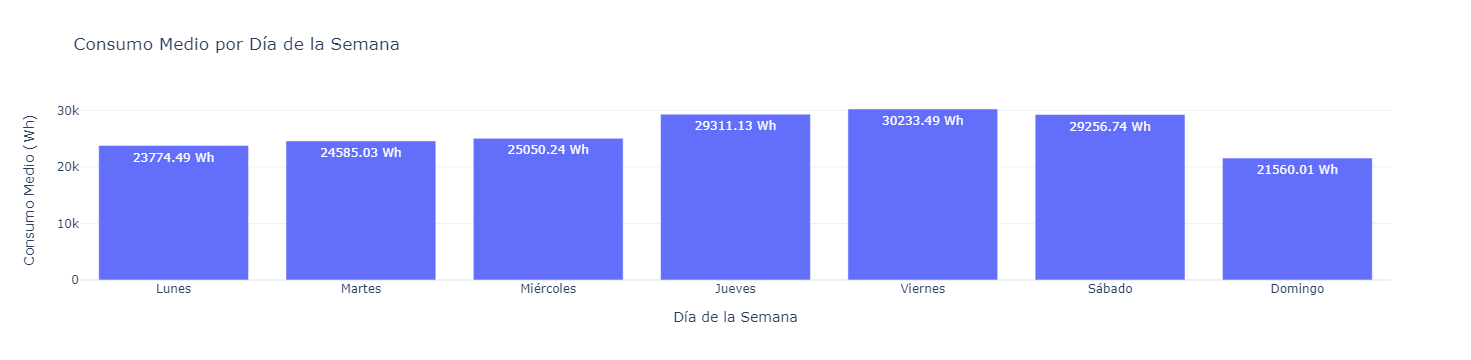

In [130]:
# Datos para el gráfico de barras
dias = list(consumo_medio_dia_semana_named.keys())
consumos = list(consumo_medio_dia_semana_named.values())

# Crear el gráfico de barras
fig = go.Figure(data=[
    go.Bar(x=dias, y=consumos, text=[f"{c:.2f} Wh" for c in consumos], textposition='auto')
])

# Añadir títulos y etiquetas
fig.update_layout(
    title='Consumo Medio por Día de la Semana',
    xaxis_title='Día de la Semana',
    yaxis_title='Consumo Medio (Wh)',
    template='plotly_white'
)

# Mostrar el gráfico
fig.show()

In [134]:
# Asegúrate de que la columna 'ts' esté en formato datetime
df_combinado['ts'] = pd.to_datetime(df_combinado['ts'])

patinetes = pd.read_csv('dimensiones_mes1.csv')

# Agrupar por 'fecha' y calcular el consumo total
consumo_por_dia = df_combinado.groupby(['fecha'])['Consumo_Wh'].sum().reset_index()

# Obtener el número total de patinetes para calcular el consumo promedio por patinete
total_patinetes = patinetes['patinetes_iniciales'].sum()

# Calcular el consumo medio por patinete y día dividiendo la columna 'Consumo_Wh' por el número total de patinetes
consumo_por_dia['Consumo_medio_por_patinete'] = consumo_por_dia['Consumo_Wh'] / total_patinetes

# Mostrar las primeras filas del resultado
consumo_por_dia


fecha  Consumo_Wh  Consumo_medio_por_patinete
0   2021-02-01    21996.36                   60.429560
1   2021-02-02    23548.13                   64.692665
2   2021-02-03    25480.43                   70.001181
3   2021-02-04    25830.91                   70.964038
4   2021-02-05    27385.67                   75.235357
5   2021-02-06    32192.26                   88.440275
6   2021-02-07    11387.60                   31.284615
7   2021-02-08    21767.20                   59.800000
8   2021-02-09    23132.00                   63.549451
9   2021-02-10    19478.84                   53.513297
10  2021-02-11    27161.03                   74.618214
11  2021-02-12    28083.90                   77.153571
12  2021-02-13    21087.64                   57.933077
13  2021-02-14    20044.77                   55.068049
14  2021-02-15    23417.19                   64.332940
15  2021-02-16    23767.85                   65.296291
16  2021-02-17    26079.37                   71.646621
17  2021-02-18    30756.59                   84.496126
18  2021-02-19    30970.28                   85.083187
19  2021-02-20    32407.38                   89.031264
20  2021-02-21    26965.01                   74.079698
21  2021-02-22    27917.19                   76.695577
22  2021-02-23    27892.12                   76.626703
23  2021-02-24    29162.33                   80.116291
24  2021-02-25    33495.99                   92.021951
25  2021-02-26    34494.10                   94.764011
26  2021-02-27    31339.69                   86.098049
27  2021-02-28    27842.65                   76.490797

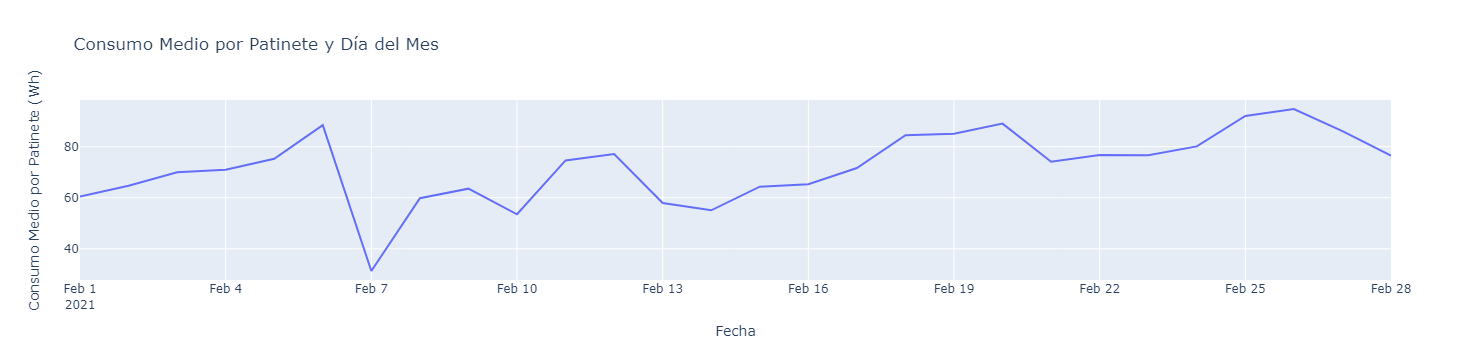

In [136]:

# Crear el gráfico de líneas con Plotly para el consumo medio por patinete y día
fig = px.line(
    consumo_por_dia, 
    x='fecha', 
    y='Consumo_medio_por_patinete', 
    title='Consumo Medio por Patinete y Día del Mes',
    labels={'fecha': 'Fecha', 'Consumo_medio_por_patinete': 'Consumo Medio por Patinete (Wh)'}
)

# Mostrar el gráfico
fig.show()

In [140]:
# Inicializar las estaciones y las variables
num_estaciones = 40
inicio_mes = dt(2021, 2, 1)
fin_mes = dt(2021, 2, 28)

# Crear una nueva columna para almacenar los patinetes necesarios cada día
consumo_por_dia['patinetes_necesarios'] = 0

# Recorrer cada día del mes y hacer la simulación para cada día
for dia in range((fin_mes - inicio_mes).days + 1):
    # Inicializar las estaciones para cada día (reiniciar a 1 los parámetros iniciales)
    estaciones = {
        i: {
            "patinetes_iniciales": 1,
            "patinetes_disponibles": 1,  # Inicialmente un patinete
            "slots": 1  # Inicialmente un slot
        }
        for i in range(num_estaciones)
    }
    
    # Definir la fecha actual y la siguiente para filtrar los datos
    fecha_actual = inicio_mes + timedelta(days=dia)
    siguiente_dia = fecha_actual + timedelta(days=1)

    # Filtrar datos del día actual
    df_dia = df_combinado[(df_combinado['ts'] >= fecha_actual) & (df_combinado['ts'] < siguiente_dia)]

    # Simular los eventos del día
    for _, evento in df_dia.iterrows():
        nodo = evento['nodo']
        tipo = evento['tipo']

        if tipo == 'origen':
            if estaciones[nodo]['patinetes_disponibles'] > 0:
                estaciones[nodo]['patinetes_disponibles'] -= 1
            else:
                estaciones[nodo]['patinetes_iniciales'] += 1
                estaciones[nodo]['patinetes_disponibles'] = 0
                if estaciones[nodo]['patinetes_iniciales'] > estaciones[nodo]['slots']:
                    estaciones[nodo]['slots'] += 1

        elif tipo == 'destino':
            if estaciones[nodo]['patinetes_disponibles'] < estaciones[nodo]['slots']:
                estaciones[nodo]['patinetes_disponibles'] += 1
            else:
                estaciones[nodo]['slots'] += 1
                estaciones[nodo]['patinetes_disponibles'] += 1

    # Calcular el total de patinetes necesarios al final del día
    patinetes_necesarios_dia = sum(estacion['patinetes_iniciales'] for estacion in estaciones.values())

    # Actualizar el DataFrame con el número de patinetes necesarios para ese día
    consumo_por_dia.loc[consumo_por_dia['fecha'] == fecha_actual.date(), 'patinetes_necesarios'] = patinetes_necesarios_dia

# Mostrar las primeras filas del resultado actualizado
consumo_por_dia

fecha  Consumo_Wh  Consumo_medio_por_patinete  patinetes_necesarios
0   2021-02-01    21996.36                   60.429560                   134
1   2021-02-02    23548.13                   64.692665                   137
2   2021-02-03    25480.43                   70.001181                   157
3   2021-02-04    25830.91                   70.964038                   161
4   2021-02-05    27385.67                   75.235357                   167
5   2021-02-06    32192.26                   88.440275                   171
6   2021-02-07    11387.60                   31.284615                   103
7   2021-02-08    21767.20                   59.800000                   160
8   2021-02-09    23132.00                   63.549451                   156
9   2021-02-10    19478.84                   53.513297                   138
10  2021-02-11    27161.03                   74.618214                   163
11  2021-02-12    28083.90                   77.153571                   163
12  2021-02-13    21087.64                   57.933077                   141
13  2021-02-14    20044.77                   55.068049                   133
14  2021-02-15    23417.19                   64.332940                   150
15  2021-02-16    23767.85                   65.296291                   138
16  2021-02-17    26079.37                   71.646621                   156
17  2021-02-18    30756.59                   84.496126                   172
18  2021-02-19    30970.28                   85.083187                   167
19  2021-02-20    32407.38                   89.031264                   168
20  2021-02-21    26965.01                   74.079698                   159
21  2021-02-22    27917.19                   76.695577                   147
22  2021-02-23    27892.12                   76.626703                   170
23  2021-02-24    29162.33                   80.116291                   170
24  2021-02-25    33495.99                   92.021951                   167
25  2021-02-26    34494.10                   94.764011                   168
26  2021-02-27    31339.69                   86.098049                   173
27  2021-02-28    27842.65                   76.490797                   168

#### Energía por hora y estación un día cualquiera


In [42]:
# Leer el archivo CSV principal
df = pd.read_csv('df_with_energy.csv')

# Convertir las columnas de fechas a formato datetime
df['tsD'] = pd.to_datetime(df['tsD'], format='%d/%m/%Y %H:%M:%S', dayfirst=True, errors='coerce')
df['tsO'] = pd.to_datetime(df['tsO'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Verificar si hay valores NaT en las columnas de fechas
if df['tsD'].isna().any() or df['tsO'].isna().any():
    print("Advertencia: Algunos valores de fecha no se pudieron convertir correctamente.")

# Crear DataFrames separados para origen y destino
df_tsO_clusterO = df[['tsO', 'clusterO', 'Consumo_Wh']].copy()
df_tsO_clusterO['Consumo_Wh'] = 0  # Inicializar a 0 el consumo para los puntos de origen
df_tsD_clusterD = df[['tsD', 'clusterD', 'Consumo_Wh']].copy()

df_tsO_clusterO['tipo'] = 'origen'
df_tsD_clusterD['tipo'] = 'destino'

# Renombrar columnas para unificar los DataFrames
df_tsO_clusterO.rename(columns={'tsO': 'ts', 'clusterO': 'nodo'}, inplace=True)
df_tsD_clusterD.rename(columns={'tsD': 'ts', 'clusterD': 'nodo'}, inplace=True)

# Concatenar ambos DataFrames
df_combinado = pd.concat([df_tsO_clusterO, df_tsD_clusterD], ignore_index=True)

# Ordenar por timestamp
df_combinado.sort_values(by='ts', inplace=True)
df_combinado.reset_index(drop=True, inplace=True)

# Filtrar por el 20 de febrero de 2021
df_combinado = df_combinado[df_combinado['ts'].dt.date == pd.Timestamp('2021-02-20').date()]

# Filtrar por viajes de destino
df_destino = df_combinado[df_combinado['tipo'] == 'destino'].copy()

# Extraer la hora de la columna 'ts'
df_destino['hora'] = df_destino['ts'].dt.hour

# Agrupar por nodo y hora, sumando los consumos
consumo_hora_estacion = df_destino.groupby(['nodo', 'hora'])['Consumo_Wh'].sum().unstack(fill_value=0)

# Leer el archivo de estaciones
estaciones = pd.read_csv('dimensiones_mes1.csv')

# Asegurar que todas las estaciones están representadas en la matriz de consumo
estaciones_ids = estaciones['estacion']
consumo_hora_estacion = consumo_hora_estacion.reindex(estaciones_ids, fill_value=0.00).sort_index()

# Asegurarse de incluir las 24 horas (incluso si no hay datos para algunas)
horas = list(range(24))
consumo_hora_estacion = consumo_hora_estacion.reindex(columns=horas, fill_value=0.00)

# Resultado
consumo_hora_estacion

hora         0    1    2    3    4       5      6       7      8       9   \
estacion                                                                    
0          0.00  0.0  0.0  0.0  0.0    0.00   0.00   26.06  39.30    0.00   
1          0.00  0.0  0.0  0.0  0.0    0.00   0.00    5.11   0.00  240.10   
2          0.00  0.0  0.0  0.0  0.0    0.00   0.00    0.00  65.79  117.90   
3          0.00  0.0  0.0  0.0  0.0    0.00   0.00    0.00   0.00   11.70   
4          0.00  0.0  0.0  0.0  0.0    0.00   0.00    0.00   0.00    0.00   
5          0.00  0.0  0.0  0.0  0.0    0.00   0.00    0.00   0.00    0.00   
6          0.00  0.0  0.0  0.0  0.0    0.00   0.00    0.00   0.00    0.00   
7          0.00  0.0  0.0  0.0  0.0    0.00   0.00    0.00   0.00    0.00   
8          0.00  0.0  0.0  0.0  0.0    0.00   0.00    0.00   0.00    0.00   
9          0.00  0.0  0.0  0.0  0.0    0.00   0.00    0.00   0.00    0.00   
10         0.00  0.0  0.0  0.0  0.0    0.00   0.00    0.00   3.19    0.00   
11         0.00  0.0  0.0  0.0  0.0    0.00   0.00    0.00   0.00    0.00   
12         0.00  0.0  0.0  0.0  0.0    0.00   0.00    0.00   0.00    0.00   
13         0.00  0.0  0.0  0.0  0.0    0.00   0.00    0.00   0.00   36.74   
14         0.00  0.0  0.0  0.0  0.0    0.00   0.00    0.00   0.00    0.00   
15         0.00  0.0  0.0  0.0  0.0    0.00   0.00    0.00   0.00    0.00   
16         0.00  0.0  0.0  0.0  0.0    0.00   0.00    0.00   0.00    0.00   
17         0.00  0.0  0.0  0.0  0.0    0.00   0.00    0.00   0.00    0.00   
18         0.00  0.0  0.0  0.0  0.0    0.00   0.00    0.00   0.00    0.00   
19         0.00  0.0  0.0  0.0  0.0    0.00   0.00   55.98   0.00    0.00   
20         0.00  0.0  0.0  0.0  0.0    0.00   0.00    0.00   0.00    0.00   
21         0.00  0.0  0.0  0.0  0.0  127.56   0.00  102.32   0.00   25.36   
22         0.00  0.0  0.0  0.0  0.0    0.00   0.00    0.00   0.00    0.00   
23         0.00  0.0  0.0  0.0  0.0    0.00   0.00    0.00   0.00  149.84   
24        14.01  0.0  0.0  0.0  0.0    0.00   0.00   20.37  11.68   31.84   
25         0.00  0.0  0.0  0.0  0.0    0.00   0.00    0.00   0.00    0.00   
26         0.00  0.0  0.0  0.0  0.0    0.00   0.00    0.00   0.00   75.22   
27         0.00  0.0  0.0  0.0  0.0    0.00  47.85    0.00  57.85    0.00   
28         0.00  0.0  0.0  0.0  0.0    0.00   0.00    0.00  59.04   35.01   
29         0.00  0.0  0.0  0.0  0.0    0.00   0.00    0.00  15.72   52.06   
30         0.00  0.0  0.0  0.0  0.0    0.00   0.00    0.00   0.00   50.43   
31         0.00  0.0  0.0  0.0  0.0    0.00   0.00    0.00   0.00    0.00   
32         0.00  0.0  0.0  0.0  0.0    0.00   0.00   40.31  93.10   61.32   
33         0.00  0.0  0.0  0.0  0.0    0.00   0.00    9.17   0.00   32.96   
34         0.00  0.0  0.0  0.0  0.0    0.00   0.00    0.00   3.28    0.00   
35         0.00  0.0  0.0  0.0  0.0    0.00   0.00    0.00   0.00   23.39   
36         0.00  0.0  0.0  0.0  0.0    0.00   0.00    0.00   0.00   38.11   
37         0.00  0.0  0.0  0.0  0.0    0.00   0.00    0.00   0.00    0.00   
38         0.00  0.0  0.0  0.0  0.0    0.00   0.00    0.00   0.00    0.00   
39         0.00  0.0  0.0  0.0  0.0    0.00   0.00    0.00   0.00    0.00   

hora      ...      14      15      16      17      18      19      20      21  \
estacion  ...                                                                   
0         ...  196.39  404.52  121.43  188.06   77.88  310.42   59.68  191.20   
1         ...   66.71  192.00  196.57  156.31  440.04   58.06   36.31    0.00   
2         ...   40.03   45.98    0.00   59.34   36.94   73.53    0.00    7.22   
3         ...   44.10   39.20    0.00    9.75   47.99    0.00   26.44   39.35   
4         ...    0.00    0.00  102.49    0.00    0.00   92.04    0.00    0.00   
5         ...  108.65  124.45  166.41  112.17   97.82   91.33   60.14  145.17   
6         ...   40.37    0.00  158.05  291.22  147.61   78.74    8.64   68.17   
7         ...   26.14   45.57   22.9

#### Consumo por hora y estacion para todo el mes de febrero

In [20]:
import pandas as pd

# Leer el archivo CSV principal
df = pd.read_csv('df_with_energy.csv')

# Convertir las columnas de fechas a formato datetime
df['tsD'] = pd.to_datetime(df['tsD'], format='%d/%m/%Y %H:%M:%S', dayfirst=True, errors='coerce')
df['tsO'] = pd.to_datetime(df['tsO'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Verificar si hay valores NaT en las columnas de fechas
if df['tsD'].isna().any() or df['tsO'].isna().any():
    print("Advertencia: Algunos valores de fecha no se pudieron convertir correctamente.")

# Crear DataFrames separados para origen y destino
df_tsO_clusterO = df[['tsO', 'clusterO', 'Consumo_Wh']].copy()
df_tsO_clusterO['Consumo_Wh'] = 0  # Inicializar a 0 el consumo para los puntos de origen
df_tsD_clusterD = df[['tsD', 'clusterD', 'Consumo_Wh']].copy()

df_tsO_clusterO['tipo'] = 'origen'
df_tsD_clusterD['tipo'] = 'destino'

# Renombrar columnas para unificar los DataFrames
df_tsO_clusterO.rename(columns={'tsO': 'ts', 'clusterO': 'nodo'}, inplace=True)
df_tsD_clusterD.rename(columns={'tsD': 'ts', 'clusterD': 'nodo'}, inplace=True)

# Concatenar ambos DataFrames
df_combinado = pd.concat([df_tsO_clusterO, df_tsD_clusterD], ignore_index=True)

# Ordenar por timestamp
df_combinado.sort_values(by='ts', inplace=True)
df_combinado.reset_index(drop=True, inplace=True)

# Filtrar solo los registros dentro del mes de febrero de 2021
df_combinado = df_combinado[
    (df_combinado['ts'].dt.month == 2) & (df_combinado['ts'].dt.year == 2021)
]

# Filtrar por viajes de destino
df_destino = df_combinado[df_combinado['tipo'] == 'destino'].copy()

# Extraer la fecha y hora de la columna 'ts'
df_destino['fecha'] = df_destino['ts'].dt.date
df_destino['hora'] = df_destino['ts'].dt.hour

# Agrupar por nodo, fecha y hora, sumando los consumos
consumo_hora_estacion = df_destino.groupby(['nodo', 'fecha', 'hora'])['Consumo_Wh'].sum()

# Leer el archivo de estaciones
estaciones = pd.read_csv('dimensiones_mes1.csv')

# Asegurar que todas las estaciones están representadas
estaciones_ids = estaciones['estacion']
horas = list(range(24))

# Crear un DataFrame con todos los días de febrero, horas y estaciones
fechas_febrero = pd.date_range(start='2021-02-01', end='2021-02-28', freq='D')
multi_index = pd.MultiIndex.from_product([estaciones_ids, fechas_febrero, horas],
                                         names=['nodo', 'fecha', 'hora'])
consumo_hora_estacion = consumo_hora_estacion.reindex(multi_index, fill_value=0.00)

# Convertir el resultado a un DataFrame
consumo_hora_estacion = consumo_hora_estacion.reset_index()

# Resultado final
consumo_hora_estacion


nodo      fecha  hora  Consumo_Wh
0         0 2021-02-01     0       19.65
1         0 2021-02-01     1        0.00
2         0 2021-02-01     2        0.00
3         0 2021-02-01     3        0.00
4         0 2021-02-01     4        0.00
...     ...        ...   ...         ...
26875    39 2021-02-28    19        0.00
26876    39 2021-02-28    20        0.00
26877    39 2021-02-28    21      128.29
26878    39 2021-02-28    22        0.00
26879    39 2021-02-28    23        0.00

[26880 rows x 4 columns]

#### Consumo medio durante el mes por hora y estación

In [22]:
import pandas as pd

# Leer el archivo CSV principal
df = pd.read_csv('df_with_energy.csv')

# Convertir las columnas de fechas a formato datetime
df['tsD'] = pd.to_datetime(df['tsD'], format='%d/%m/%Y %H:%M:%S', dayfirst=True, errors='coerce')
df['tsO'] = pd.to_datetime(df['tsO'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Verificar si hay valores NaT en las columnas de fechas
if df['tsD'].isna().any() or df['tsO'].isna().any():
    print("Advertencia: Algunos valores de fecha no se pudieron convertir correctamente.")

# Crear DataFrames separados para origen y destino
df_tsO_clusterO = df[['tsO', 'clusterO', 'Consumo_Wh']].copy()
df_tsO_clusterO['Consumo_Wh'] = 0  # Inicializar a 0 el consumo para los puntos de origen
df_tsD_clusterD = df[['tsD', 'clusterD', 'Consumo_Wh']].copy()

df_tsO_clusterO['tipo'] = 'origen'
df_tsD_clusterD['tipo'] = 'destino'

# Renombrar columnas para unificar los DataFrames
df_tsO_clusterO.rename(columns={'tsO': 'ts', 'clusterO': 'nodo'}, inplace=True)
df_tsD_clusterD.rename(columns={'tsD': 'ts', 'clusterD': 'nodo'}, inplace=True)

# Concatenar ambos DataFrames
df_combinado = pd.concat([df_tsO_clusterO, df_tsD_clusterD], ignore_index=True)

# Ordenar por timestamp
df_combinado.sort_values(by='ts', inplace=True)
df_combinado.reset_index(drop=True, inplace=True)

# Filtrar datos para el mes deseado (por ejemplo, febrero de 2021)
df_combinado = df_combinado[(df_combinado['ts'].dt.year == 2021) & (df_combinado['ts'].dt.month == 2)]

# Filtrar por viajes de destino
df_destino = df_combinado[df_combinado['tipo'] == 'destino'].copy()

# Extraer la hora de la columna 'ts'
df_destino['hora'] = df_destino['ts'].dt.hour

# Agrupar por nodo y hora, calculando la media de los consumos
consumo_hora_estacion = df_destino.groupby(['nodo', 'hora'])['Consumo_Wh'].mean().unstack(fill_value=0)

# Leer el archivo de estaciones
estaciones = pd.read_csv('dimensiones_mes1.csv')

# Asegurar que todas las estaciones están representadas en la matriz de consumo
estaciones_ids = estaciones['estacion']
consumo_hora_estacion = consumo_hora_estacion.reindex(estaciones_ids, fill_value=0.00).sort_index()

# Asegurarse de incluir las 24 horas (incluso si no hay datos para algunas)
horas = list(range(24))
consumo_hora_estacion = consumo_hora_estacion.reindex(columns=horas, fill_value=0.00)

# Resultado
consumo_hora_estacion


hora             0       1          2       3      4          5          6   \
estacion                                                                      
0         36.426667  17.680   0.000000   0.000   0.00   1.770000   0.000000   
1          0.000000  21.420   0.000000   0.000   0.00  42.666667  12.240000   
2         69.882500  91.540  34.025000   0.000   0.00  30.700000   0.000000   
3         48.055000   0.000   0.000000   0.000   3.63   0.000000   9.160000   
4          0.000000   0.000   0.000000   0.000   0.00  20.570000  39.820000   
5         26.717500   0.000   0.000000  28.380  31.24   0.000000  36.330000   
6         70.720000  54.075   0.000000   0.000   0.00   0.000000  19.205000   
7          0.000000   0.000   0.000000   0.000   0.00   0.000000   0.000000   
8         26.885000  42.190   0.000000   0.005   0.00   0.000000  17.705000   
9         33.825000   0.000   0.000000   0.000   0.00  20.850000  20.850000   
10         0.000000   0.000   0.000000   0.000   0.00  23.875000  22.393333   
11        14.095000   0.000   0.000000   0.000   0.00   0.000000   0.000000   
12         5.110000   0.000   0.000000   0.000   0.00   0.000000   0.000000   
13        31.580000   0.000   0.000000   0.000  23.45   0.000000   0.000000   
14        31.570000   0.000   0.000000   0.000   0.00   0.000000   0.000000   
15        17.360000   0.000   0.000000   0.000   0.00   0.000000   0.000000   
16         0.000000   0.000   0.000000   0.000   0.00   0.000000   0.000000   
17         0.000000   0.000   8.350000   0.710   0.00  86.010000  34.180000   
18         0.000000   0.000  12.986667   0.000   0.00  21.380000  26.203333   
19        11.200000   0.000   0.000000   0.000   0.00   0.000000  12.430000   
20         0.000000   0.000   0.000000   0.000   0.00   0.000000  55.310000   
21         0.000000   0.000  26.810000   0.000   0.00  63.780000   0.000000   
22         0.000000   7.550   7.900000   0.000   7.70   0.000000   0.000000   
23         5.160000   5.110   2.450000   0.000   0.00   0.000000   0.000000   
24         7.655000   0.000   0.010000   0.000   0.00   0.000000  14.820000   
25         0.000000   0.000   0.000000   0.000   0.00   0.000000   0.000000   
26         0.000000  10.210   0.000000   0.000   0.00   0.000000   0.580000   
27         0.000000  41.220   0.000000   0.000   0.00   0.000000  19.990000   
28         7.130000  59.460   0.000000   0.000   0.00   0.000000  35.416364   
29        11.250000   0.000   6.683333   0.000   0.00   0.000000  28.700000   
30        24.130000   0.000   0.000000   0.000   0.00   0.000000   0.000000   
31        31.460000   0.000   0.000000   0.000   0.00   0.000000  25.210000   
32        32.120000  18.680  27.990000   0.000   0.00  37.733333  35.096000   
33         0.000000   0.000   0.000000   0.000   0.00   0.000000   0.000000   
34         0.000000   0.000   0.000000   0.000   0.00   0.000000   8.880000   
35         3.880000   0.000   0.000000   0.000   0.00   0.000000   0.000000   
36         0.000000   0.000   0.000000   0.000   0.00  32.240000  30.825000   
37         0.000000   0.000   0.000000   0.000   0.00   0.000000   0.000000   
38         0.000000   0.000   0.000000   0.000   0.00  62.530000   0.000000   
39        10.590000  61.840   0.000000   0.000   0.00   0.000000  28.275000   

hora             7          8          9   ...         14         15  \
estacion                                   ...                         
0         23.170000  15.828661  17.350143  ...  25.622885  20.667941   
1         43.632381  33.195556  50.824677  ...  32.653488  36.891268   
2         45.656364  39.021250  26.614706  ...  31.490444  32.427091   
3         25.950000  42.697500  17.014286  ...  32.503793  31.787273   
4         31.680000  30.980000  26.732222  ...  26.678000  26.445333   
5         46.000435  29.800000  30.950732  ...  32.733043  31.472308   
6         56.964000  39.483519  40.179032  ...  34.423562  35.727000   
7         19.996970  18.973846  1

In [7]:
# Guardar el resultado en un archivo CSV
output_file = 'consumo_hora_estacion.csv'
consumo_hora_estacion.to_csv(output_file, index=True)

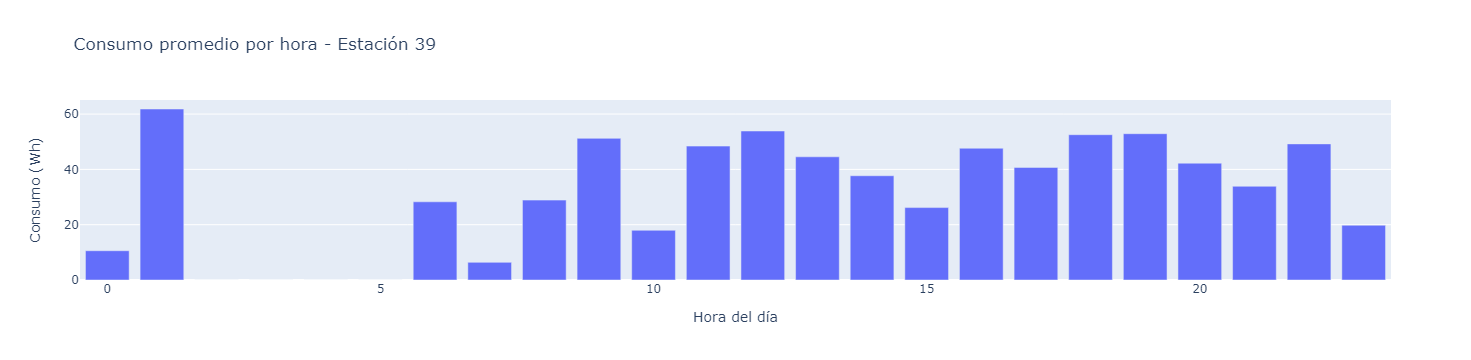

In [31]:
# Seleccionar una estación al azar
estacion_aleatoria = random.choice(consumo_hora_estacion.index)

# Preparar los datos para el gráfico
df_grafico = consumo_hora_estacion.loc[estacion_aleatoria].reset_index()
df_grafico.columns = ['Hora', 'Consumo_Wh']

# Crear el gráfico de barras
fig = px.bar(
    df_grafico,
    x='Hora',
    y='Consumo_Wh',
    title=f'Consumo promedio por hora - Estación {estacion_aleatoria}',
    labels={'Hora': 'Hora del día', 'Consumo_Wh': 'Consumo (Wh)'},
)

# Mostrar el gráfico
fig.show()

#### Energía producida por estación y hora


In [24]:
energia_solar = pd.read_excel('GeneracionHorariaFVRomaFebrero.xlsx')
energia_solar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Fecha_hora           672 non-null    datetime64[ns]
 1   Generacion (kWh/m2)  672 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 10.6 KB


In [26]:
# Carga de datos
energia_solar = pd.read_excel('GeneracionHorariaFVRomaFebrero.xlsx')
df = pd.read_csv('dimensiones_mes1.csv')

# Cálculo del área de paneles solares para cada estación
area_slot = 0.566 * 1.1
df['area_paneles'] = df['slots'] * area_slot

# Crear un DataFrame con combinaciones de estaciones y horas
combined = pd.merge(
    energia_solar.assign(key=1),  # Añadimos una clave común para el cruce
    df.assign(key=1),
    on='key'
).drop('key', axis=1)

# Calcular la energía producida por cada estación
combined['energia_estacion_kWh'] = (
    combined['Generacion (kWh/m2)'] * combined['area_paneles']
)

# Agrupar por día y hora si es necesario
combined['Fecha'] = combined['Fecha_hora'].dt.date
combined['Hora'] = combined['Fecha_hora'].dt.hour

# Mostramos el resultado por día, hora y estación
energia_por_estacion = combined[['Fecha', 'Hora', 'estacion', 'energia_estacion_kWh']]

energia_por_estacion


Fecha  Hora  estacion  energia_estacion_kWh
0      2021-02-01     0         0                   0.0
1      2021-02-01     0         1                   0.0
2      2021-02-01     0         2                   0.0
3      2021-02-01     0         3                   0.0
4      2021-02-01     0         4                   0.0
...           ...   ...       ...                   ...
26875  2021-02-28    23        35                   0.0
26876  2021-02-28    23        36                   0.0
26877  2021-02-28    23        37                   0.0
26878  2021-02-28    23        38                   0.0
26879  2021-02-28    23        39                   0.0

[26880 rows x 4 columns]

#### Energía media producida por hora y estación

In [ ]:
# Calcular la producción media por hora y estación
produccion_media = energia_por_estacion.groupby(['Hora', 'estacion'])['energia_estacion_kWh'].mean().reset_index()

# Renombrar la columna para mayor claridad
produccion_media.rename(columns={'energia_estacion_kWh': 'produccion_media_kWh'}, inplace=True)
output_file = 'produccion_hora_estacion.csv'
produccion_media.to_csv(output_file, index=True)
# Mostrar un resumen de los datos
produccion_media

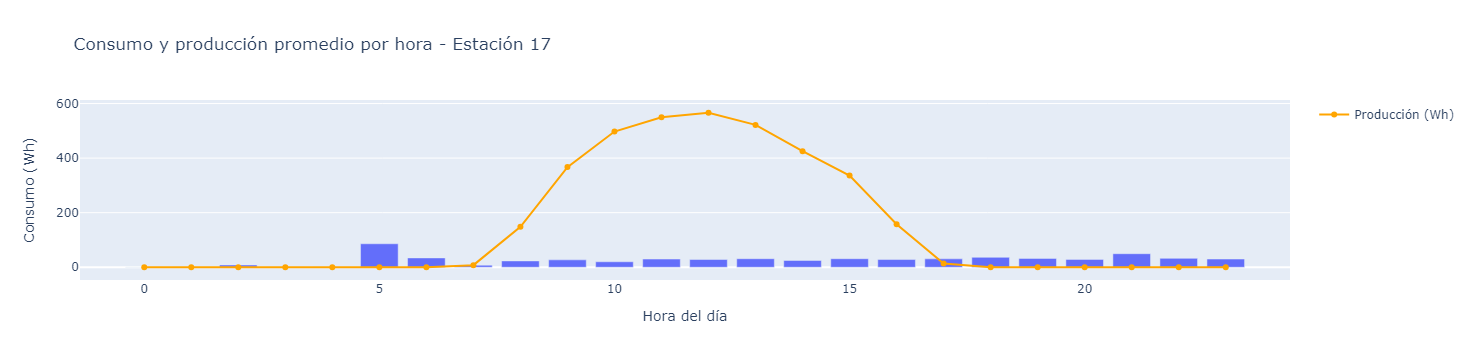

In [118]:
df_consumo = pd.read_csv('consumo_hora_estacion.csv')
produccion_media = pd.read_csv('produccion_hora_estacion.csv')
# Convertir la producción media a Wh
produccion_media['produccion_media_Wh'] = produccion_media['produccion_media_kWh'] * 1000

# Seleccionar una estación al azar
estacion_aleatoria = random.choice(consumo_hora_estacion.index)

# Preparar los datos de consumo para el gráfico
df_consumo = consumo_hora_estacion.loc[estacion_aleatoria].reset_index()
df_consumo.columns = ['Hora', 'Consumo_Wh']

# Filtrar los datos de producción para la estación seleccionada
df_produccion = produccion_media[produccion_media['estacion'] == estacion_aleatoria][['Hora', 'produccion_media_Wh']]

# Unir los datos de consumo y producción para facilitar el gráfico
df_grafico = df_consumo.merge(df_produccion, on='Hora', how='left')

# Crear el gráfico
fig = px.bar(
    df_grafico,
    x='Hora',
    y='Consumo_Wh',
    title=f'Consumo y producción promedio por hora - Estación {estacion_aleatoria}',
    labels={'Hora': 'Hora del día', 'Consumo_Wh': 'Consumo (Wh)', 'produccion_media_Wh': 'Producción (Wh)'},
)

# Añadir la línea de producción
fig.add_scatter(
    x=df_grafico['Hora'],
    y=df_grafico['produccion_media_Wh'],
    mode='lines+markers',
    name='Producción (Wh)',
    line=dict(color='orange')
)

# Mostrar el gráfico
fig.show()

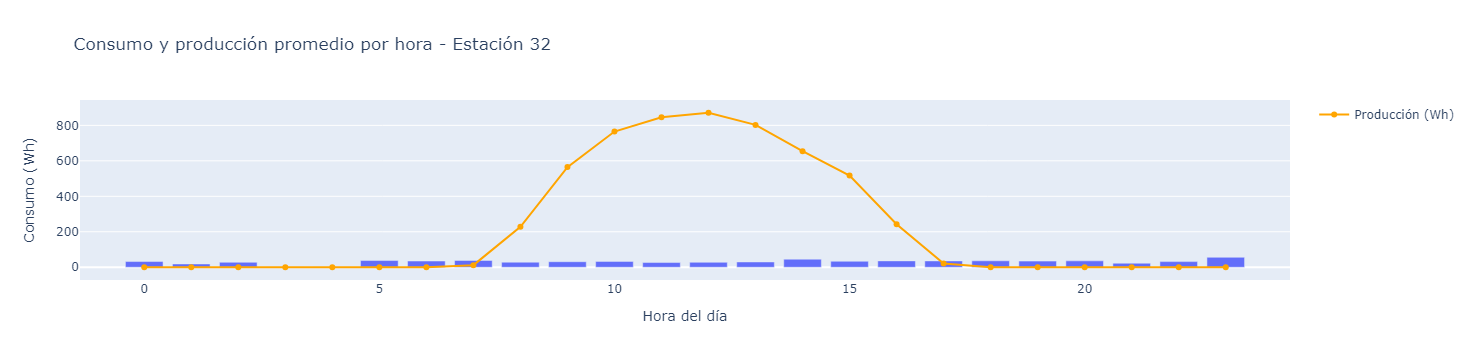

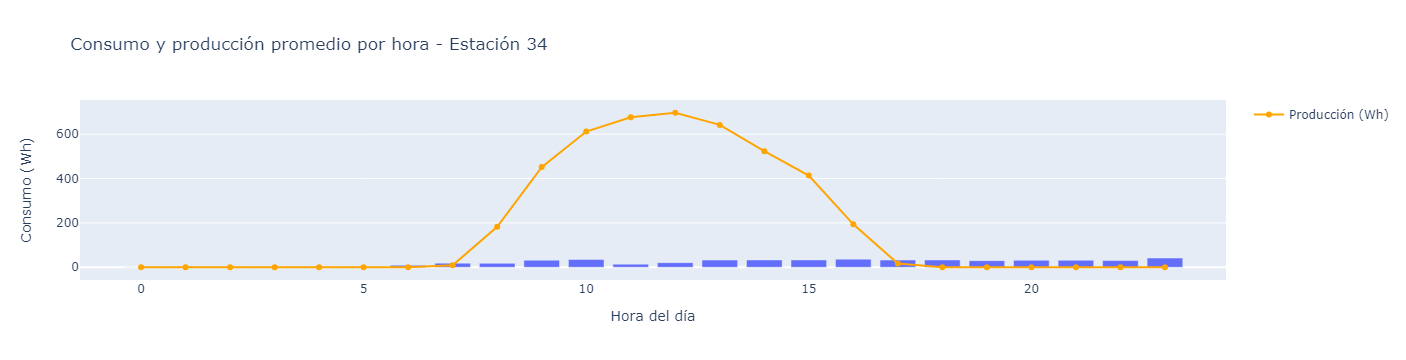

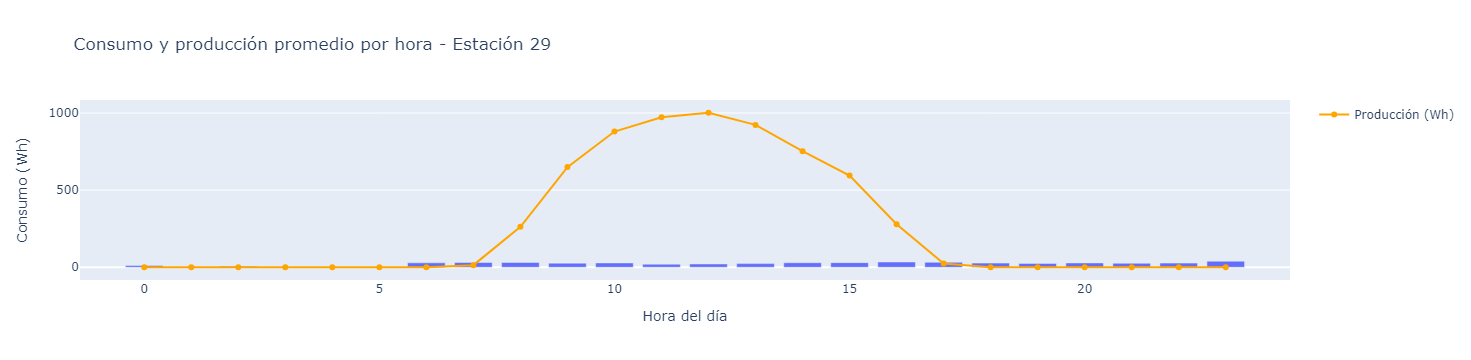

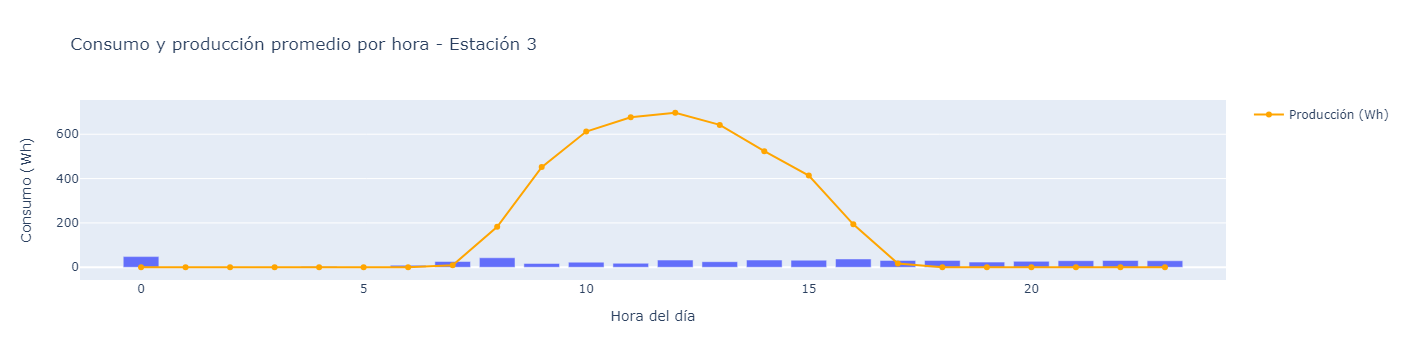

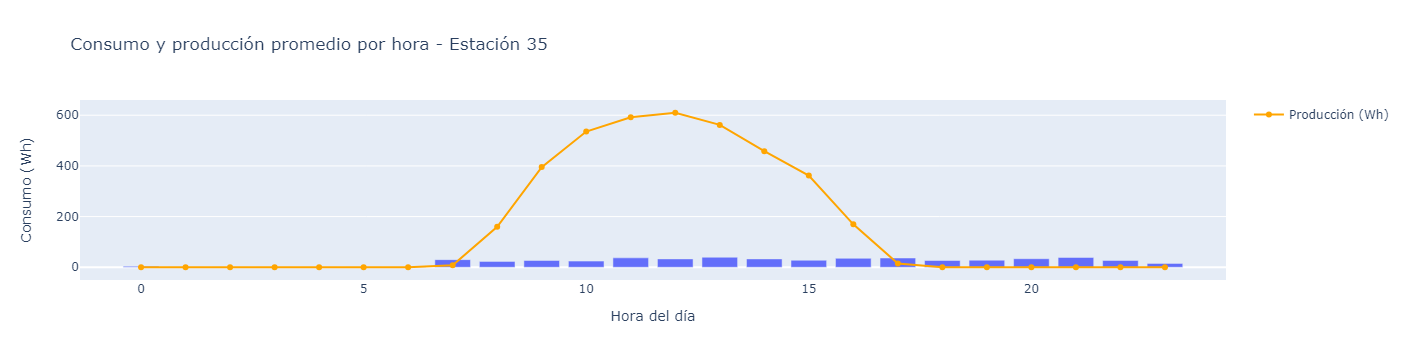

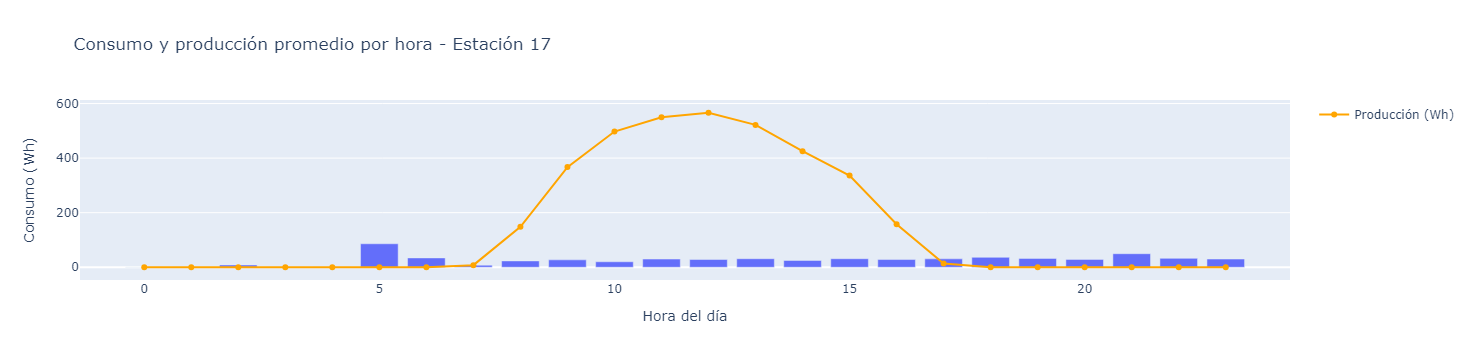

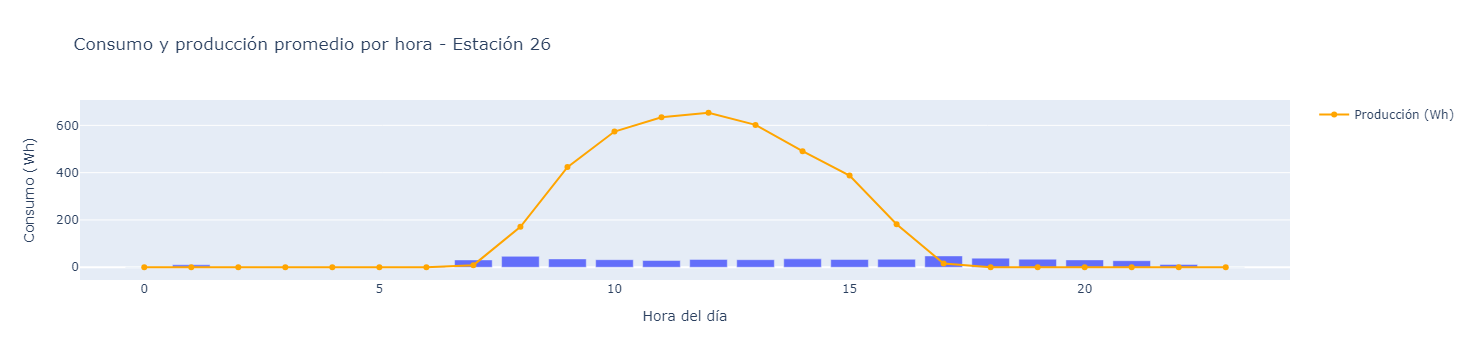

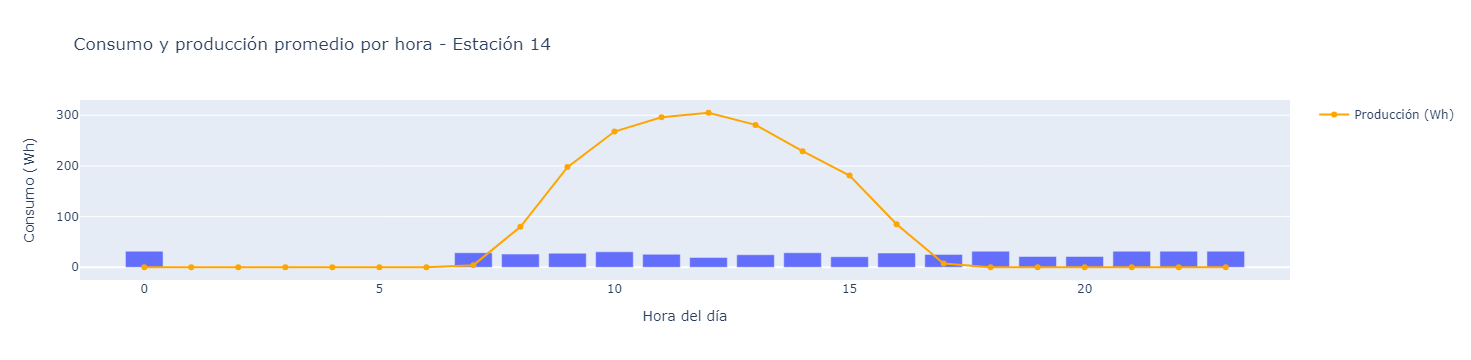

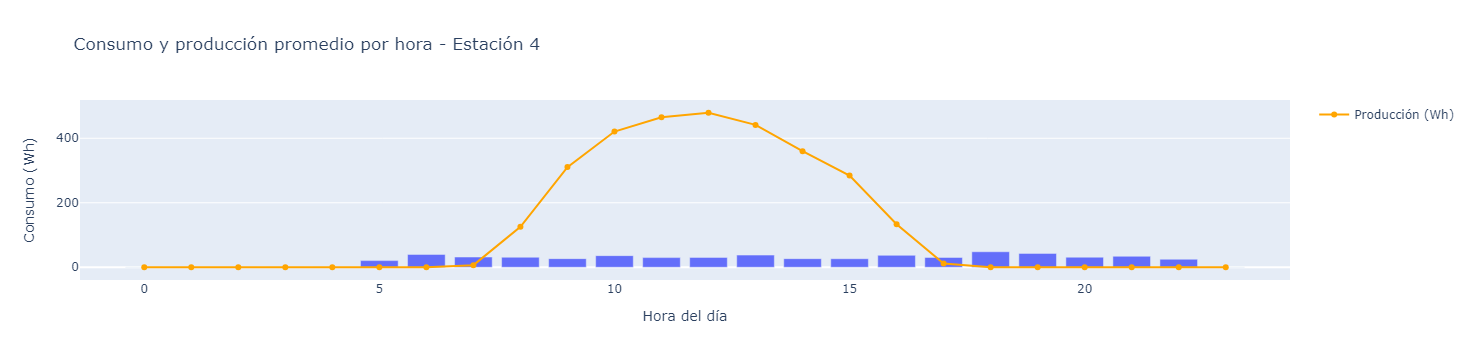

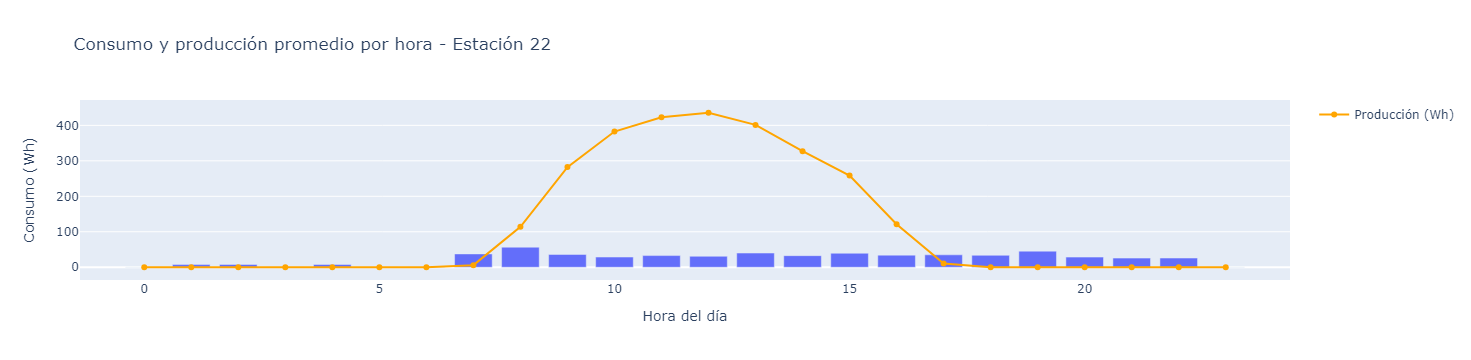

Producción media diaria de la red de paneles solares: 183678.63197354 Wh


In [120]:
df_consumo = pd.read_csv('consumo_hora_estacion.csv')
produccion_media = pd.read_csv('produccion_hora_estacion.csv')
# Convertir la producción media a Wh
produccion_media['produccion_media_Wh'] = produccion_media['produccion_media_kWh'] * 1000

# Seleccionar 10 estaciones al azar
estaciones_aleatorias = random.sample(list(consumo_hora_estacion.index), 10)

# Iterar sobre las estaciones seleccionadas
for estacion in estaciones_aleatorias:
    # Preparar los datos de consumo para el gráfico
    df_consumo = consumo_hora_estacion.loc[estacion].reset_index()
    df_consumo.columns = ['Hora', 'Consumo_Wh']

    # Filtrar los datos de producción para la estación seleccionada
    df_produccion = produccion_media[produccion_media['estacion'] == estacion][['Hora', 'produccion_media_Wh']]

    # Unir los datos de consumo y producción para facilitar el gráfico
    df_grafico = df_consumo.merge(df_produccion, on='Hora', how='left')

    # Crear el gráfico
    fig = px.bar(
        df_grafico,
        x='Hora',
        y='Consumo_Wh',
        title=f'Consumo y producción promedio por hora - Estación {estacion}',
        labels={'Hora': 'Hora del día', 'Consumo_Wh': 'Consumo (Wh)', 'produccion_media_Wh': 'Producción (Wh)'},
    )

    # Añadir la línea de producción
    fig.add_scatter(
        x=df_grafico['Hora'],
        y=df_grafico['produccion_media_Wh'],
        mode='lines+markers',
        name='Producción (Wh)',
        line=dict(color='orange')
    )

    # Mostrar el gráfico
    fig.show()
print(f"Producción media diaria de la red de paneles solares: {produccion_media['produccion_media_Wh'].sum()} Wh")


### Producción ajustada (equivalente a reducción de área de paneles solares)

In [123]:
energia_consumida_media = 26253.01 #Wh
energia_producida_media = 183678.63 #Wh
energia_producida_objetivo = 35000 #Wh
factor_ajuste = energia_producida_objetivo/energia_producida_media
# Leer el archivo CSV
produccion_media = pd.read_csv('produccion_hora_estacion.csv')

# Añadir una nueva columna ajustada
produccion_media['produccion_ajustada'] = produccion_media['produccion_media_kWh']*factor_ajuste

produccion_media.to_csv('produccion_hora_estacion.csv', index=True)
# Mostrar el resultado
produccion_media.head()

Unnamed: 0  Hora  estacion  produccion_media_kWh  produccion_ajustada
0           0     0         0                   0.0                  0.0
1           1     0         1                   0.0                  0.0
2           2     0         2                   0.0                  0.0
3           3     0         3                   0.0                  0.0
4           4     0         4                   0.0                  0.0

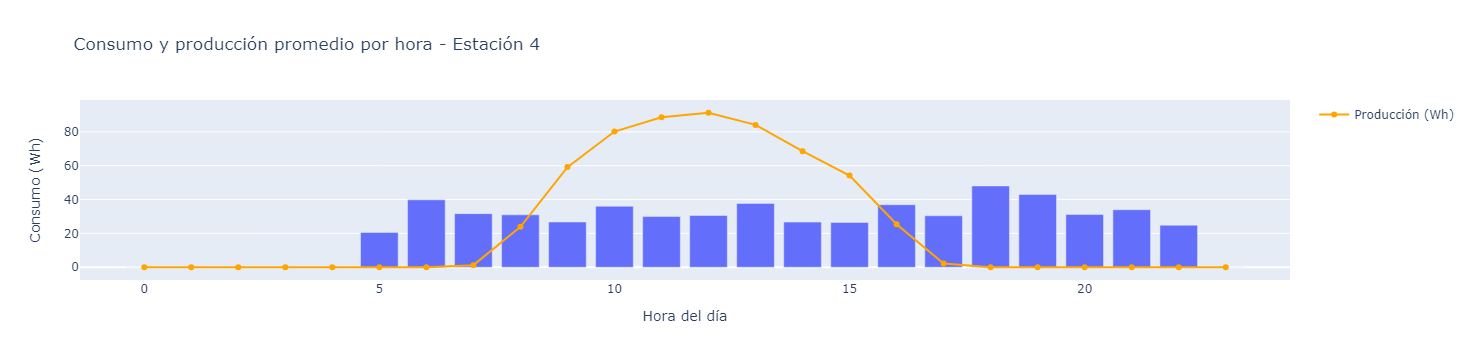

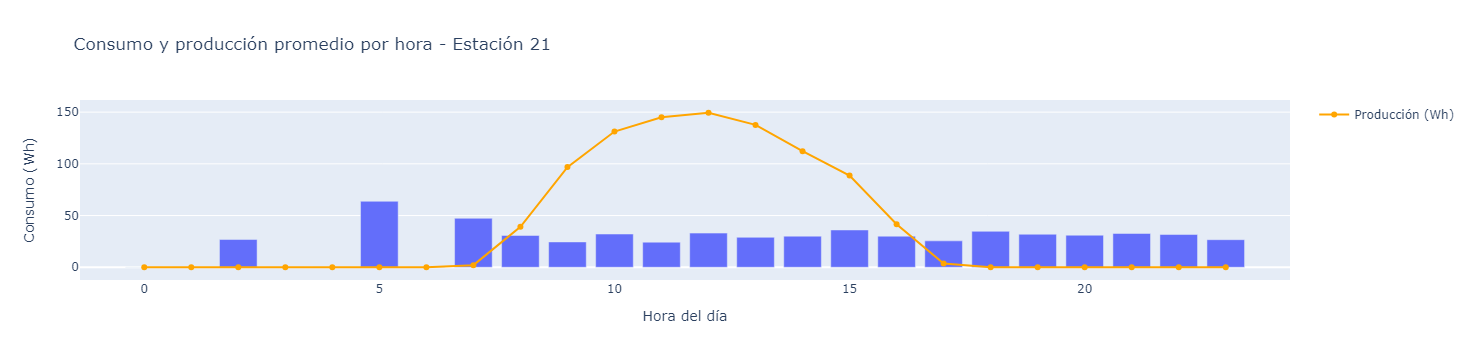

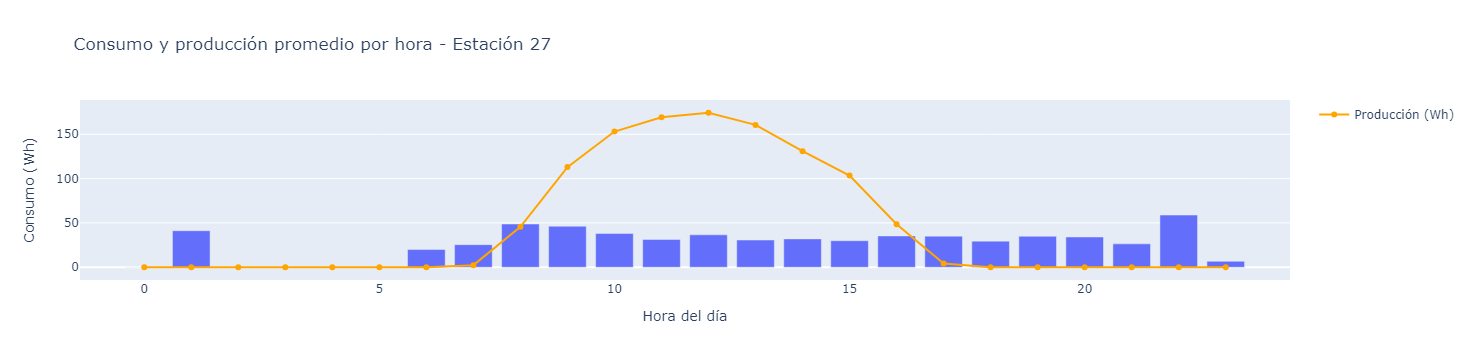

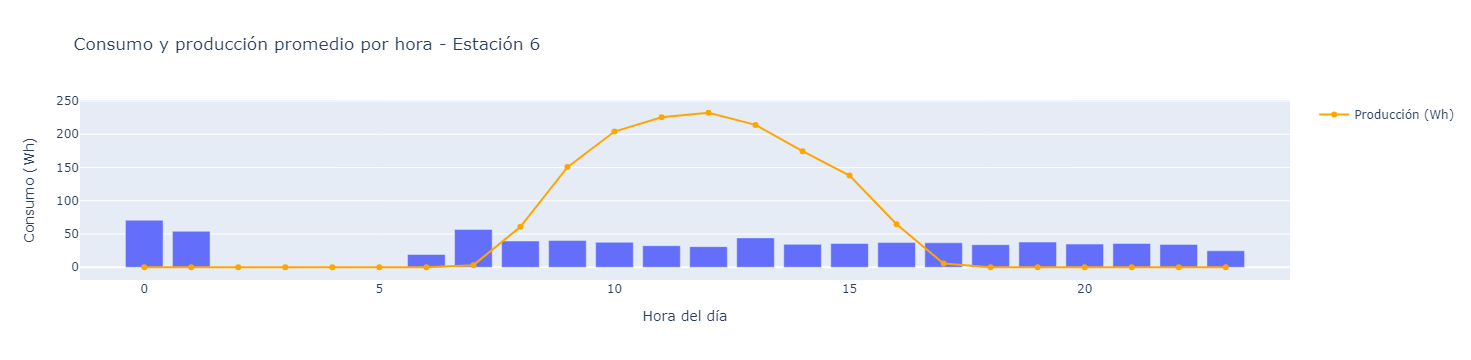

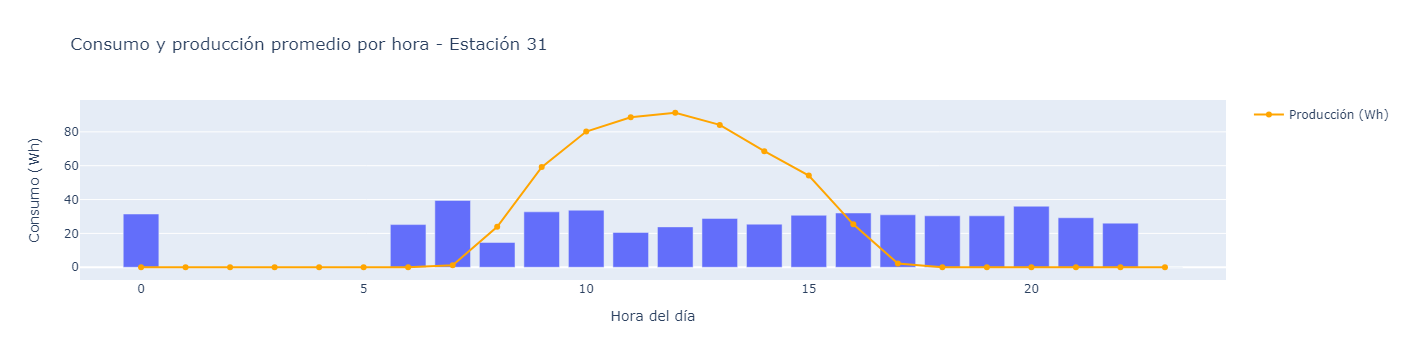

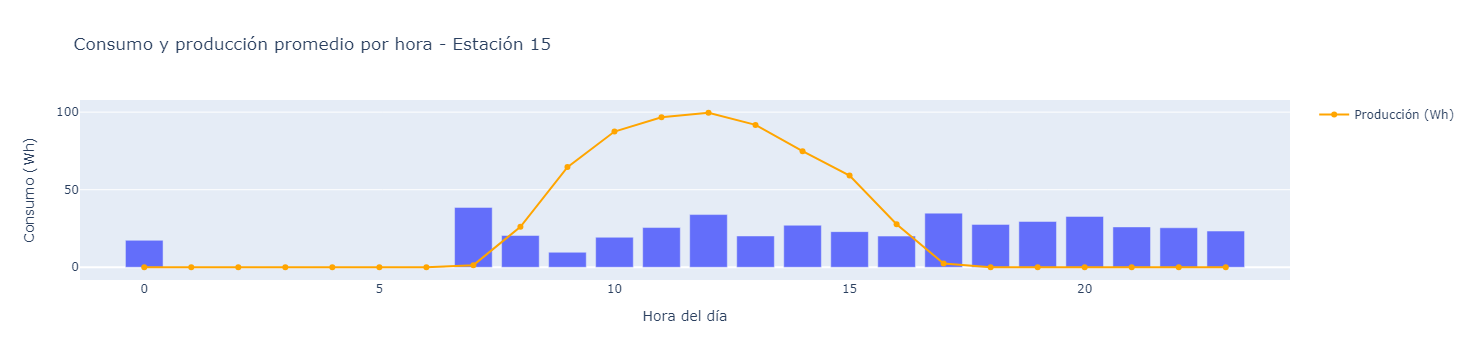

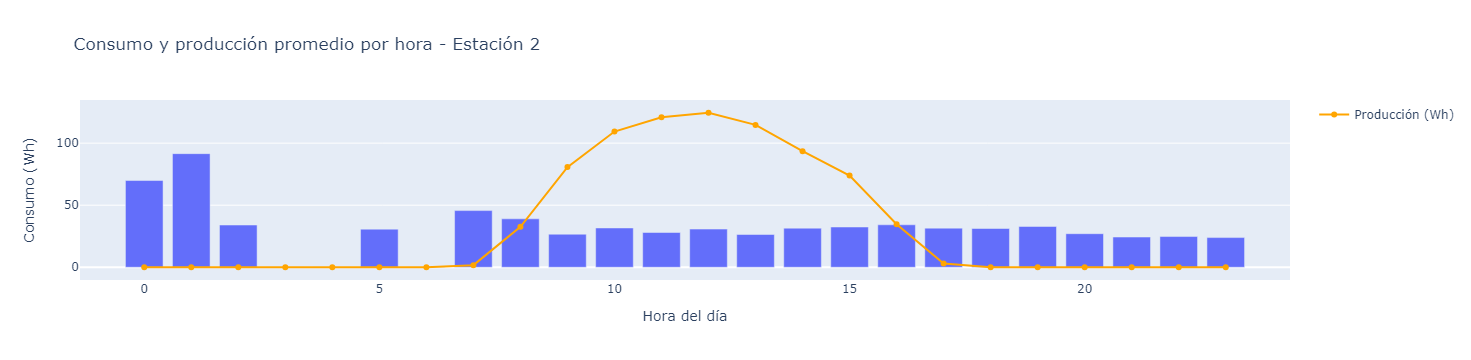

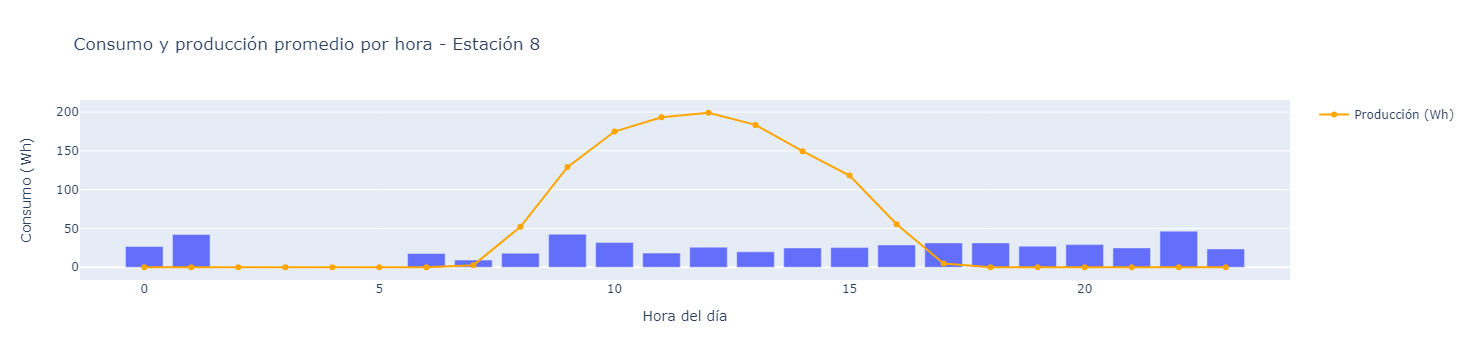

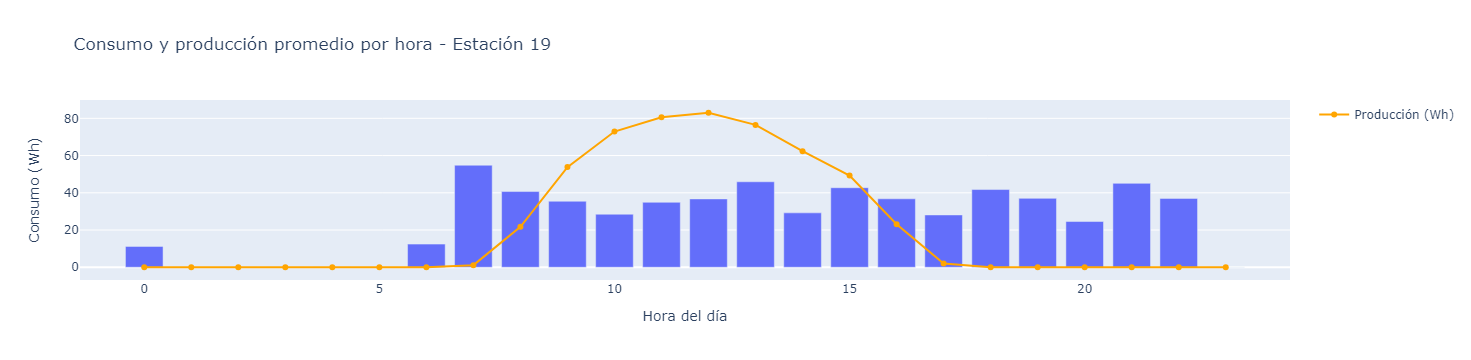

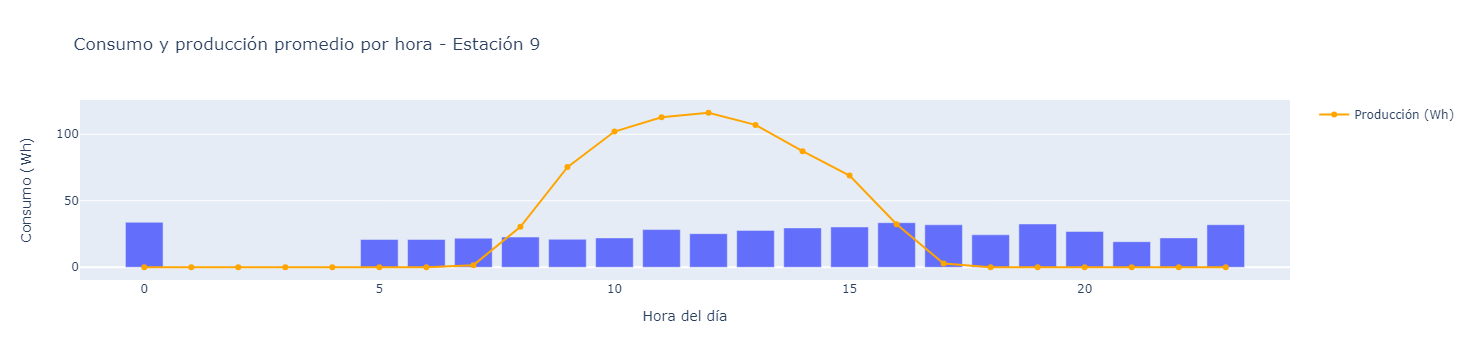

In [125]:
df_consumo = pd.read_csv('consumo_hora_estacion.csv')
produccion_media = pd.read_csv('produccion_hora_estacion.csv')
# Convertir la producción media a Wh
produccion_media['produccion_media_Wh'] = produccion_media['produccion_ajustada'] * 1000

# Seleccionar 10 estaciones al azar
estaciones_aleatorias = random.sample(list(consumo_hora_estacion.index), 10)

# Iterar sobre las estaciones seleccionadas
for estacion in estaciones_aleatorias:
    # Preparar los datos de consumo para el gráfico
    df_consumo = consumo_hora_estacion.loc[estacion].reset_index()
    df_consumo.columns = ['Hora', 'Consumo_Wh']

    # Filtrar los datos de producción para la estación seleccionada
    df_produccion = produccion_media[produccion_media['estacion'] == estacion][['Hora', 'produccion_media_Wh']]

    # Unir los datos de consumo y producción para facilitar el gráfico
    df_grafico = df_consumo.merge(df_produccion, on='Hora', how='left')

    # Crear el gráfico
    fig = px.bar(
        df_grafico,
        x='Hora',
        y='Consumo_Wh',
        title=f'Consumo y producción promedio por hora - Estación {estacion}',
        labels={'Hora': 'Hora del día', 'Consumo_Wh': 'Consumo (Wh)', 'produccion_media_Wh': 'Producción (Wh)'},
    )

    # Añadir la línea de producción
    fig.add_scatter(
        x=df_grafico['Hora'],
        y=df_grafico['produccion_media_Wh'],
        mode='lines+markers',
        name='Producción (Wh)',
        line=dict(color='orange')
    )

    # Mostrar el gráfico
    fig.show()

In [ ]:
# Iterar sobre las estaciones seleccionadas
for estacion in estaciones_aleatorias:
    # Preparar los datos de consumo para el gráfico
    df_consumo = consumo_hora_estacion.loc[estacion].reset_index()
    df_consumo.columns = ['Hora', 'Consumo_Wh']

    # Filtrar los datos de producción para la estación seleccionada
    df_produccion = produccion_media[produccion_media['estacion'] == estacion][['Hora', 'produccion_media_Wh']]

    # Unir los datos de consumo y producción para facilitar el cálculo
    df_grafico = df_consumo.merge(df_produccion, on='Hora', how='left')

    # Calcular la energía sobrante
    df_grafico['Energia_sobrante_Wh'] = df_grafico['produccion_media_Wh'] - df_grafico['Consumo_Wh']

    # Reemplazar valores negativos por 0 (opcional, si no quieres valores negativos de energía sobrante)
    df_grafico['Energia_sobrante_Wh'] = df_grafico['Energia_sobrante_Wh'].clip(lower=0)

    # Crear el gráfico
    fig = px.bar(
        df_grafico,
        x='Hora',
        y='Consumo_Wh',
        title=f'Consumo, producción y energía sobrante por hora - Estación {estacion}',
        labels={
            'Hora': 'Hora del día',
            'Consumo_Wh': 'Consumo (Wh)',
            'produccion_media_Wh': 'Producción (Wh)',
            'Energia_sobrante_Wh': 'Energía sobrante (Wh)'
        },
    )

    # Añadir las líneas de producción y energía sobrante
    fig.add_scatter(
        x=df_grafico['Hora'],
        y=df_grafico['produccion_media_Wh'],
        mode='lines+markers',
        name='Producción (Wh)',
        line=dict(color='orange')
    )

    fig.add_scatter(
        x=df_grafico['Hora'],
        y=df_grafico['Energia_sobrante_Wh'],
        mode='lines+markers',
        name='Energía sobrante (Wh)',
        line=dict(color='green')
    )

    # Mostrar el gráfico
    fig.show()